## UNSER UNET

- Ideal : Batch size 7

In [1]:
# Check the /tmp folder !!

Trying with different tmp

SyntaxError: invalid syntax (1040872811.py, line 3)

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.nn.functional as F
import copy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from skimage import measure
from tqdm import tqdm  # for progress bars
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
## Adj
# Directory Setup
current_dir = os.getcwd()

# Training/Validation directory
target_dir_train = os.path.join(current_dir, "DATA", "572x572_train")
#target_dir_train = os.path.join(current_dir, "drive", "MyDrive", "Colab Notebooks", "DATA", "572x572_train_withOcc")
# Test directory for evaluation
target_dir_test = os.path.join(current_dir, "DATA", "Test_24")

print("Training directory:", target_dir_train)
print("Test directory:", target_dir_test)



Training directory: /app/DATA/572x572_train
Test directory: /app/DATA/Test_24


Input Data: 572x572x3

In [4]:
def rgb2int(arr):
    """
    Convert (N,...M,3)-array of dtype uint8 to a (N,...,M)-array of dtype int32
    """
    return arr[...,0]*(256**2)+arr[...,1]*256+arr[...,2]

def rgb2vals(color, color2ind):
    int_colors = rgb2int(color)
    int_keys = rgb2int(np.array(color2ind.keys(), dtype='uint8'))
    int_array = np.r_[int_colors.ravel(), int_keys]
    uniq, index = np.unique(int_array, return_inverse=True)
    color_labels = index[:int_colors.size]
    key_labels = index[-len(color2ind):]

    colormap = np.empty_like(int_keys, dtype='uint32')
    colormap[key_labels] = color2ind.values()
    out = colormap[color_labels].reshape(color.shape[:2])
    return out


class EarlyStopping:
    def __init__(self, patience=7, min_delta=5e-6, verbose=True):
        """
        patience: How many epochs to wait before stopping after last improvement
        min_delta: Minimum change to qualify as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.min_validation_loss = float('inf')

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


def calculate_metrics(pred, target):
    """
    Calculate IoU (Intersection over Union) and Dice coefficient for each class
    pred: tensor of shape [B, C, H, W] (predictions)
    target: tensor of shape [B, H, W] (ground truth)
    """
    num_classes = pred.shape[1]
    pred_classes = pred.argmax(dim=1)  # Convert to class indices [B, H, W]
    metrics = {}

    # Calculate per-class metrics
    for class_idx in range(num_classes):
        pred_mask = (pred_classes == class_idx)
        target_mask = (target == class_idx)

        intersection = (pred_mask & target_mask).sum().float()
        union = (pred_mask | target_mask).sum().float()

        # IoU (Intersection over Union)
        iou = (intersection + 1e-6) / (union + 1e-6)

        # Dice coefficient
        dice = (2 * intersection + 1e-6) / (pred_mask.sum() + target_mask.sum() + 1e-6)

        metrics[f'iou_class_{class_idx}'] = iou.item()
        metrics[f'dice_class_{class_idx}'] = dice.item()

    # Calculate mean metrics
    metrics['mean_iou'] = np.mean([v for k, v in metrics.items() if k.startswith('iou')])
    metrics['mean_dice'] = np.mean([v for k, v in metrics.items() if k.startswith('dice')])

    return metrics

class ModelCheckpointer:
    def __init__(self, save_dir, metrics_to_monitor=None):
        """
        save_dir: directory to save model checkpoints
        metrics_to_monitor: list of tuples (metric_name, mode)
                          mode can be 'min' for loss or 'max' for accuracy metrics
        """
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

        if metrics_to_monitor is None:
            self.metrics_to_monitor = [('val_loss', 'min'), ('mean_iou', 'max')]
        else:
            self.metrics_to_monitor = metrics_to_monitor

        self.best_metrics = {metric: float('inf') if mode == 'min' else float('-inf')
                           for metric, mode in self.metrics_to_monitor}

    def update(self, model, epoch, metrics):
        """
        Check if current metrics are better than best metrics and save if they are
        """
        improved = False

        for metric_name, mode in self.metrics_to_monitor:
            current = metrics.get(metric_name)
            if current is None:
                continue

            is_better = (mode == 'min' and current < self.best_metrics[metric_name]) or \
                       (mode == 'max' and current > self.best_metrics[metric_name])

            if is_better:
                improved = True
                self.best_metrics[metric_name] = current

                # Save checkpoint
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'metrics': metrics,
                    'best_metrics': self.best_metrics
                }

                torch.save(checkpoint,
                          os.path.join(self.save_dir, f'best_{metric_name}_model.pth'))

        return improved


class FacadeDataset(Dataset):
    def __init__(self, conf_map_dir, ground_truth_dir, transform=None):
        self.conf_map_dir = conf_map_dir
        self.ground_truth_dir = ground_truth_dir
        self.transform = transform

        # Updated color mappings for conflict map
        self.CONFLICT_MAP_COLORS = {
            'confirming': (0, 255, 0),  # Green - Confirming
            'unknown': (0, 0, 255),     # Blue - Unknown
            'conflict': (255, 0, 0)     # Red - Conflict
        }

        # Define color to class mapping for ground truth
        self.COLOR_TO_CLASS = {
            (0, 0, 255): 0,    # Facade - Blue
            (0, 85, 255): 1,   # Window - Light Blue
            (0, 170, 255): 2,  # Door - Lighter Blue
            (0, 0, 170): 3     # Background/Occlusion - Dark Blue
        }

        self.conf_map_files = sorted([f for f in os.listdir(conf_map_dir)
                                 if f.endswith('.png')])
        print(f"Found {len(self.conf_map_files)} images in {conf_map_dir}")

        self.ground_truth_files = sorted([f for f in os.listdir(ground_truth_dir)
                                 if f.endswith('.png')])
        print(f"Found {len(self.ground_truth_files)} images in {ground_truth_dir}")

    def __len__(self):
        return len(self.conf_map_files)

    def __getitem__(self, idx):
        conf_map_name = self.conf_map_files[idx]
        ground_truth_name = self.ground_truth_files[idx]
        conf_map_path = os.path.join(self.conf_map_dir, conf_map_name)
        ground_truth_path = os.path.join(self.ground_truth_dir, ground_truth_name)

        # Load conflict map as RGB
        conf_map = Image.open(conf_map_path).convert('RGB')
        conf_map_array = np.array(conf_map)

        # Create input channels based on different conflict map states
        confirming_mask = np.all(conf_map_array == self.CONFLICT_MAP_COLORS['confirming'], axis=2)
        unknown_mask = np.all(conf_map_array == self.CONFLICT_MAP_COLORS['unknown'], axis=2)
        conflict_mask = np.all(conf_map_array == self.CONFLICT_MAP_COLORS['conflict'], axis=2)

        # Stack the masks into a 3-channel tensor
        conf_map_tensor = np.stack([confirming_mask, unknown_mask, conflict_mask], axis=0)
        conf_map_tensor = torch.from_numpy(conf_map_tensor).float()

        # Load ground truth and convert to numpy array
        ground_truth_array = np.array(Image.open(ground_truth_path))

        # Initialize the class array
        H, W = ground_truth_array.shape[:2]
        class_array = np.zeros((H, W), dtype=np.int64)

        # Vectorized class assignment
        for color, class_idx in self.COLOR_TO_CLASS.items():
            mask = np.all(ground_truth_array[:, :, :3] == color, axis=2)
            class_array[mask] = class_idx

        # Convert to tensor
        class_array = torch.from_numpy(class_array)

        return conf_map_tensor, class_array




def get_facade_dataloaders(base_dir, batch_size=4, mode='train'):
    """Create train, validation, or test dataloaders"""
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = FacadeDataset(
        conf_map_dir=os.path.join(base_dir, 'ResizedConflictMaps'),
        ground_truth_dir=os.path.join(base_dir, 'ResizedGroundTruth'),
        transform=transform
    )

    if mode == 'train':
        # Split into train/val sets
        train_size = int(0.824 * len(dataset)) ## (70/15/(15) split)
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=3,
            pin_memory=torch.cuda.is_available()
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0
        )

        return {'train': train_loader, 'val': val_loader}

    else:  # test mode
        test_loader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2
        )

        return test_loader

def train_facade_model(model, base_dir, num_epochs=50, batch_size=4, patience=7):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    dataloaders = get_facade_dataloaders(base_dir, batch_size=batch_size)

    # Initialize checkpointer and early stopping
    checkpointer = ModelCheckpointer(
        save_dir='model_checkpoints',
        metrics_to_monitor=[
            ('val_loss', 'min'),
            ('mean_iou', 'max'),
            ('mean_dice', 'max')
        ]
    )
    early_stopping = EarlyStopping(patience=patience, min_delta = 5e-5, verbose=True)

    #class_weights = torch.tensor([1.0, 1.0, 2.0, 1.0]).to(device)  # Higher weight for door class (index 2)
    criterion = nn.CrossEntropyLoss()
    
 
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


    model = model.to(device)
    best_model = None

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        epoch_metrics = {}

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            all_metrics = defaultdict(float)
            batch_count = 0

            for inputs, ground_truth in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                ground_truth = ground_truth.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, ground_truth)

                    batch_metrics = calculate_metrics(outputs, ground_truth)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                batch_count += 1

                for metric_name, value in batch_metrics.items():
                    all_metrics[metric_name] += value

            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_metrics[f'{phase}_loss'] = epoch_loss

            for metric_name, total_value in all_metrics.items():
                epoch_metrics[f'{phase}_{metric_name}'] = total_value / batch_count

            
            for metric_name, value in epoch_metrics.items():
                if phase in metric_name:
                    print(f'{metric_name}: {value:.4f}')

        # Update learning rate
        scheduler.step() 

        # Save checkpoint if improved
        if checkpointer.update(model, epoch, epoch_metrics):
            print("Saved new best model!")
            best_model = copy.deepcopy(model)

        # Early stopping check
        early_stopping(epoch_metrics['val_loss'])
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        print()

    return best_model or model  # Return best model if we have one, otherwise current model

def predict_facade(model, image_path, device):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    image = Image.open(image_path).convert('1')  # Convert to binary
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)  # Shape: [1, 4, H, W]
        pred = output.argmax(1).squeeze().cpu().numpy()  # Convert to class indices

    return pred


In [5]:
# DEBuG
# Test the dataset loading
try:
    dataloaders = get_facade_dataloaders(target_dir_train, batch_size=1)
    print("\nSuccessfully created dataloaders!")

    # Test a batch
    train_loader = dataloaders['train']
    sample_batch = next(iter(train_loader))
    conf_map, ground_truth = sample_batch
    print(f"\nBatch shapes:")
    print(f"Conf_Map: {conf_map.shape}")
    #print(conf_map[0][0][0])
    print(f"Ground_Truth: {ground_truth.shape}")
    #print(ground_truth[0][0][0])

    # Print information about the datasets
    print("\nDataset information:")
    print(f"Number of batches in training loader: {len(dataloaders['train'])}")
    print(f"Number of batches in validation loader: {len(dataloaders['val'])}")

except Exception as e:
    print(f"Error occurred: {str(e)}")

# Also test the test dataloader
try:
    test_loader = get_facade_dataloaders(target_dir_test, batch_size=1, mode='test')
    print("\nSuccessfully created test dataloader!")

    # Test a batch from test loader
    test_batch = next(iter(test_loader))
    test_conf_map, test_ground_truth = test_batch
    print(f"\nTest batch shapes:")
    print(f"Conf_Map: {test_conf_map.shape}")
    print(f"Ground_Truth: {test_ground_truth.shape}")
    print(f"Number of batches in test loader: {len(test_loader)}")

except Exception as e:
    print(f"Error occurred with test loader: {str(e)}")

Found 3728 images in /app/DATA/572x572_train/ResizedConflictMaps
Found 3728 images in /app/DATA/572x572_train/ResizedGroundTruth

Successfully created dataloaders!

Batch shapes:
Conf_Map: torch.Size([1, 3, 572, 572])
Ground_Truth: torch.Size([1, 572, 572])

Dataset information:
Number of batches in training loader: 3071
Number of batches in validation loader: 657
Found 24 images in /app/DATA/Test_24/ResizedConflictMaps
Found 24 images in /app/DATA/Test_24/ResizedGroundTruth

Successfully created test dataloader!

Test batch shapes:
Conf_Map: torch.Size([1, 3, 572, 572])
Ground_Truth: torch.Size([1, 572, 572])
Number of batches in test loader: 24


In [6]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Define class names within the class to avoid the global reference error
        self.class_names = ['Facade', 'Window', 'Door', 'Unknown']
        
        # Encoder
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding='same')  # Using 'same' padding
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding='same')
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding='same')
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding='same')
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding='same')
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding='same')
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding='same')

        # Decoder with size-matching upconvolution
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding='same')
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding='same')

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding='same')
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding='same')

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding='same')
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding='same')

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding='same')
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding='same')

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

        self.epoch = 0
        self.debug_plot = False  # Add flag to control debug plotting

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder with size checking
        xu1 = self.upconv1(xe52)
        # Ensure sizes match for concatenation
        if xu1.size() != xe42.size():
            xu1 = torch.nn.functional.interpolate(xu1, size=xe42.size()[2:])
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        if xu2.size() != xe32.size():
            xu2 = torch.nn.functional.interpolate(xu2, size=xe32.size()[2:])
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        if xu3.size() != xe22.size():
            xu3 = torch.nn.functional.interpolate(xu3, size=xe22.size()[2:])
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        if xu4.size() != xe12.size():
            xu4 = torch.nn.functional.interpolate(xu4, size=xe12.size()[2:])
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        self.epoch += 1
        
        # Only plot in debug mode and when running with a display
        if self.debug_plot and self.epoch % 10 == 0:
            try:
                import matplotlib.pyplot as plt
                for i, class_name in enumerate(self.class_names):
                    plt.subplot(1, len(self.class_names), i + 1)
                    plt.title(f'Class: {class_name}')
                    plt.imshow(out.cpu().detach().numpy()[0][i], cmap='gray')
                    plt.axis('off')
                    plt.colorbar()
                
                plt.tight_layout()
                plt.savefig(f'debug_plot_epoch_{self.epoch}.png')
                plt.close()
            except Exception as e:
                print(f"Debug plotting failed: {e}")

        return out

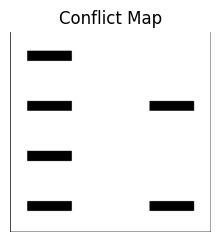

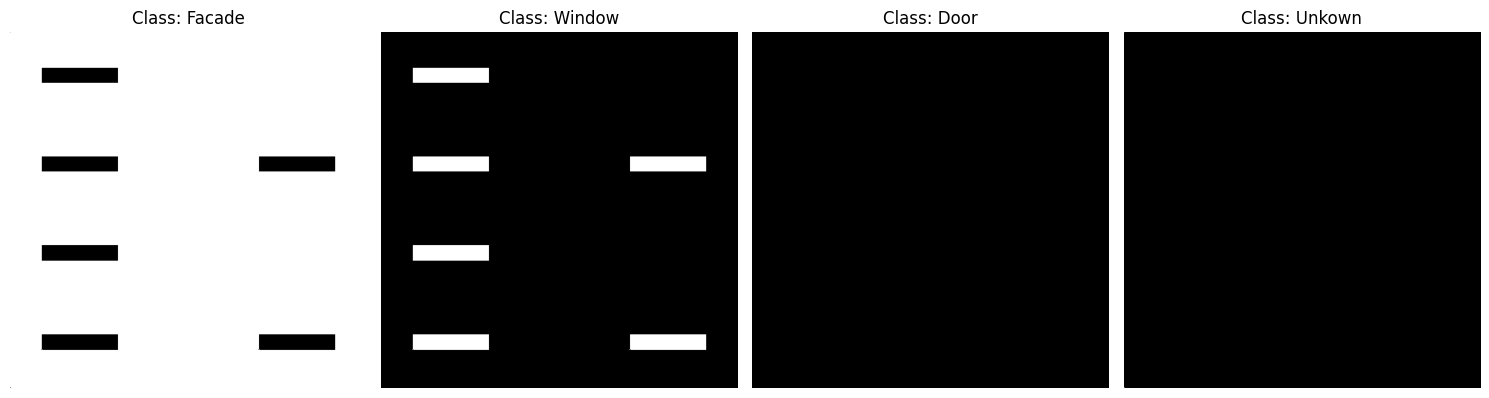

<Figure size 640x480 with 0 Axes>

In [7]:
# Get a single batch
train_loader = dataloaders['train']
sample_batch = next(iter(train_loader))
conf_maps, ground_truth = sample_batch

# Convert first image from batch to numpy for visualization
conf_map = conf_maps[0].numpy()  # Shape: [1, 572, 572]
ground_truth = ground_truth[0].numpy()  # Shape: [4, 572, 572]

# Create a figure with subplots
plt.figure(figsize=(15, 5))

# Plot conflict map
plt.subplot(151)
plt.title('Conflict Map')
plt.imshow(conf_map[0], cmap='gray')
plt.axis('off')

# Class names and their encoded values
class_names = ['Facade', 'Window', 'Door', 'Unkown']

plt.figure(figsize=(15, 5))

test_output = torch.empty(1, 4, 572, 572)

for i, class_name in enumerate(class_names):
    plt.subplot(1, len(class_names), i + 1)  # Create subplots in a single row
    plt.title(f'Class: {class_name}')

    # Create binary mask for the current class
    class_mask = (ground_truth == i).astype(int)
    plt.imshow(class_mask, cmap='gray')
    plt.axis('off')
    test_output[0][i] = torch.from_numpy(class_mask)

plt.tight_layout()
plt.show()

test_ground_truth = torch.empty(1, 572, 572)
test_ground_truth[0] = torch.from_numpy(ground_truth)

#AA = nn.CrossEntropyLoss()(test_output.long(), test_ground_truth.long())
##print(AA)
plt.tight_layout()
plt.show()

Bildgröße: torch.Size([1, 3, 572, 572])


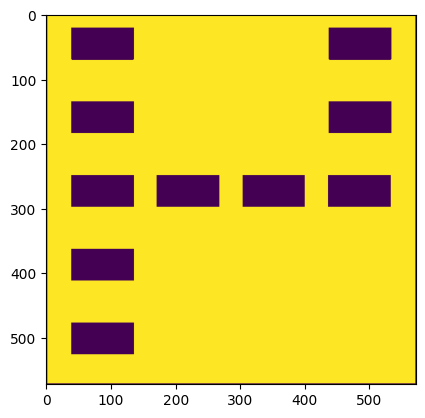

In [8]:
for images, labels in dataloaders['train']:
    print(f"Bildgröße: {images.size()}")
    image1 = images[0];
    plt.imshow(image1[0][0:572][0:572])
    break

# Training

Documentation of the runtime:
- on GPU with all images (size 572x572):
 Took 1h30m

- on GPU with all images (size 572x572):
 Took 1h (only 30 iterations)

- overfitting single image --> 300 iterations -->

- One Run on 4000 images --> 16:25min for 1 Train cycle // 6:25 min for validation cycle

- 24.02.: on GPU 125 epochs, with Occ and no Occ --> 1:35h

In [9]:
# Clear CUDA cache and set parameters
import torch
torch.cuda.empty_cache()
batch_size = 14
num_epochs = 50
patience = 10

# Initialize model
model = UNet(n_class=4)  # Create model with 3 input channels

# Train the model using training/validation data
trained_model = train_facade_model(
    model=model,
    base_dir=target_dir_train,
    num_epochs=num_epochs,
    batch_size=batch_size,
    patience=patience
)

#
#model_name = f'Facade_model_b{batch_size}_e{num_epochs}_CMPGEN_nS.pth'
model_name = f'Facade_model_b{batch_size}_e{num_epochs}_CMPGENREAL_nS.pth'

# Save the trained model
save_path = os.path.join(current_dir, "pth und eval", model_name)
print(f"Saving model to: {save_path}")
torch.save(trained_model.state_dict(), save_path)

Using device: cuda:0
Found 3728 images in /app/DATA/572x572_train/ResizedConflictMaps
Found 3728 images in /app/DATA/572x572_train/ResizedGroundTruth
Epoch 0/49
----------


100%|██████████| 220/220 [04:34<00:00,  1.25s/it]


train_loss: 0.1526
train_iou_class_0: 0.9731
train_dice_class_0: 0.9854
train_iou_class_1: 0.7658
train_dice_class_1: 0.8248
train_iou_class_2: 0.1483
train_dice_class_2: 0.2080
train_iou_class_3: 0.8578
train_dice_class_3: 0.8737
train_mean_iou: 0.6863
train_mean_dice: 0.7230


100%|██████████| 47/47 [03:15<00:00,  4.17s/it]


val_loss: 0.0297
val_iou_class_0: 0.9957
val_dice_class_0: 0.9979
val_iou_class_1: 0.9065
val_dice_class_1: 0.9502
val_iou_class_2: 0.5444
val_dice_class_2: 0.6908
val_iou_class_3: 0.9682
val_dice_class_3: 0.9837
val_mean_iou: 0.8537
val_mean_dice: 0.9056
Saved new best model!

Epoch 1/49
----------


100%|██████████| 220/220 [04:40<00:00,  1.28s/it]


train_loss: 0.0281
train_iou_class_0: 0.9960
train_dice_class_0: 0.9980
train_iou_class_1: 0.9068
train_dice_class_1: 0.9505
train_iou_class_2: 0.5098
train_dice_class_2: 0.6526
train_iou_class_3: 0.9637
train_dice_class_3: 0.9770
train_mean_iou: 0.8441
train_mean_dice: 0.8945


100%|██████████| 47/47 [03:09<00:00,  4.03s/it]


val_loss: 0.0229
val_iou_class_0: 0.9964
val_dice_class_0: 0.9982
val_iou_class_1: 0.9244
val_dice_class_1: 0.9602
val_iou_class_2: 0.6100
val_dice_class_2: 0.7453
val_iou_class_3: 0.9734
val_dice_class_3: 0.9864
val_mean_iou: 0.8761
val_mean_dice: 0.9225
Saved new best model!

Epoch 2/49
----------


100%|██████████| 220/220 [04:40<00:00,  1.28s/it]


train_loss: 0.0217
train_iou_class_0: 0.9973
train_dice_class_0: 0.9986
train_iou_class_1: 0.9271
train_dice_class_1: 0.9617
train_iou_class_2: 0.5912
train_dice_class_2: 0.7237
train_iou_class_3: 0.9822
train_dice_class_3: 0.9909
train_mean_iou: 0.8745
train_mean_dice: 0.9187


100%|██████████| 47/47 [03:16<00:00,  4.19s/it]


val_loss: 0.0214
val_iou_class_0: 0.9978
val_dice_class_0: 0.9989
val_iou_class_1: 0.9302
val_dice_class_1: 0.9635
val_iou_class_2: 0.5844
val_dice_class_2: 0.7282
val_iou_class_3: 0.9876
val_dice_class_3: 0.9937
val_mean_iou: 0.8750
val_mean_dice: 0.9211
Saved new best model!

Epoch 3/49
----------


100%|██████████| 220/220 [04:39<00:00,  1.27s/it]


train_loss: 0.0194
train_iou_class_0: 0.9979
train_dice_class_0: 0.9990
train_iou_class_1: 0.9294
train_dice_class_1: 0.9629
train_iou_class_2: 0.6096
train_dice_class_2: 0.7345
train_iou_class_3: 0.9774
train_dice_class_3: 0.9818
train_mean_iou: 0.8786
train_mean_dice: 0.9196


100%|██████████| 47/47 [03:17<00:00,  4.20s/it]


val_loss: 0.0205
val_iou_class_0: 0.9979
val_dice_class_0: 0.9990
val_iou_class_1: 0.9138
val_dice_class_1: 0.9539
val_iou_class_2: 0.4823
val_dice_class_2: 0.6377
val_iou_class_3: 0.9899
val_dice_class_3: 0.9949
val_mean_iou: 0.8460
val_mean_dice: 0.8964
Saved new best model!

Epoch 4/49
----------


100%|██████████| 220/220 [04:39<00:00,  1.27s/it]


train_loss: 0.0181
train_iou_class_0: 0.9981
train_dice_class_0: 0.9990
train_iou_class_1: 0.9352
train_dice_class_1: 0.9662
train_iou_class_2: 0.6293
train_dice_class_2: 0.7527
train_iou_class_3: 0.9815
train_dice_class_3: 0.9861
train_mean_iou: 0.8860
train_mean_dice: 0.9260


100%|██████████| 47/47 [03:19<00:00,  4.25s/it]


val_loss: 0.0186
val_iou_class_0: 0.9978
val_dice_class_0: 0.9989
val_iou_class_1: 0.9365
val_dice_class_1: 0.9669
val_iou_class_2: 0.6379
val_dice_class_2: 0.7683
val_iou_class_3: 0.9881
val_dice_class_3: 0.9940
val_mean_iou: 0.8901
val_mean_dice: 0.9320
Saved new best model!

Epoch 5/49
----------


100%|██████████| 220/220 [04:39<00:00,  1.27s/it]


train_loss: 0.0182
train_iou_class_0: 0.9981
train_dice_class_0: 0.9991
train_iou_class_1: 0.9329
train_dice_class_1: 0.9648
train_iou_class_2: 0.6353
train_dice_class_2: 0.7543
train_iou_class_3: 0.9833
train_dice_class_3: 0.9871
train_mean_iou: 0.8874
train_mean_dice: 0.9263


100%|██████████| 47/47 [03:19<00:00,  4.25s/it]


val_loss: 0.0172
val_iou_class_0: 0.9981
val_dice_class_0: 0.9991
val_iou_class_1: 0.9399
val_dice_class_1: 0.9687
val_iou_class_2: 0.6924
val_dice_class_2: 0.8030
val_iou_class_3: 0.9917
val_dice_class_3: 0.9958
val_mean_iou: 0.9055
val_mean_dice: 0.9416
Saved new best model!

Epoch 6/49
----------


100%|██████████| 220/220 [04:39<00:00,  1.27s/it]


train_loss: 0.0171
train_iou_class_0: 0.9982
train_dice_class_0: 0.9991
train_iou_class_1: 0.9361
train_dice_class_1: 0.9667
train_iou_class_2: 0.6400
train_dice_class_2: 0.7626
train_iou_class_3: 0.9745
train_dice_class_3: 0.9781
train_mean_iou: 0.8872
train_mean_dice: 0.9266


100%|██████████| 47/47 [03:22<00:00,  4.30s/it]


val_loss: 0.0163
val_iou_class_0: 0.9982
val_dice_class_0: 0.9991
val_iou_class_1: 0.9421
val_dice_class_1: 0.9699
val_iou_class_2: 0.7019
val_dice_class_2: 0.8093
val_iou_class_3: 0.9927
val_dice_class_3: 0.9963
val_mean_iou: 0.9087
val_mean_dice: 0.9436
Saved new best model!

Epoch 7/49
----------


100%|██████████| 220/220 [04:39<00:00,  1.27s/it]


train_loss: 0.0174
train_iou_class_0: 0.9982
train_dice_class_0: 0.9991
train_iou_class_1: 0.9352
train_dice_class_1: 0.9661
train_iou_class_2: 0.6546
train_dice_class_2: 0.7730
train_iou_class_3: 0.9793
train_dice_class_3: 0.9828
train_mean_iou: 0.8918
train_mean_dice: 0.9302


100%|██████████| 47/47 [03:15<00:00,  4.16s/it]


val_loss: 0.0178
val_iou_class_0: 0.9979
val_dice_class_0: 0.9990
val_iou_class_1: 0.9369
val_dice_class_1: 0.9671
val_iou_class_2: 0.6937
val_dice_class_2: 0.8027
val_iou_class_3: 0.9902
val_dice_class_3: 0.9950
val_mean_iou: 0.9047
val_mean_dice: 0.9409
EarlyStopping counter: 1 out of 10

Epoch 8/49
----------


100%|██████████| 220/220 [04:39<00:00,  1.27s/it]


train_loss: 0.0163
train_iou_class_0: 0.9983
train_dice_class_0: 0.9991
train_iou_class_1: 0.9389
train_dice_class_1: 0.9681
train_iou_class_2: 0.6820
train_dice_class_2: 0.7985
train_iou_class_3: 0.9899
train_dice_class_3: 0.9926
train_mean_iou: 0.9022
train_mean_dice: 0.9396


100%|██████████| 47/47 [03:17<00:00,  4.21s/it]


val_loss: 0.0167
val_iou_class_0: 0.9982
val_dice_class_0: 0.9991
val_iou_class_1: 0.9412
val_dice_class_1: 0.9694
val_iou_class_2: 0.7006
val_dice_class_2: 0.8085
val_iou_class_3: 0.9928
val_dice_class_3: 0.9964
val_mean_iou: 0.9082
val_mean_dice: 0.9433
EarlyStopping counter: 2 out of 10

Epoch 9/49
----------


100%|██████████| 220/220 [04:38<00:00,  1.27s/it]


train_loss: 0.0160
train_iou_class_0: 0.9983
train_dice_class_0: 0.9991
train_iou_class_1: 0.9388
train_dice_class_1: 0.9680
train_iou_class_2: 0.6723
train_dice_class_2: 0.7825
train_iou_class_3: 0.9856
train_dice_class_3: 0.9882
train_mean_iou: 0.8987
train_mean_dice: 0.9345


100%|██████████| 47/47 [03:20<00:00,  4.27s/it]


val_loss: 0.0158
val_iou_class_0: 0.9983
val_dice_class_0: 0.9991
val_iou_class_1: 0.9438
val_dice_class_1: 0.9708
val_iou_class_2: 0.7082
val_dice_class_2: 0.8131
val_iou_class_3: 0.9941
val_dice_class_3: 0.9970
val_mean_iou: 0.9111
val_mean_dice: 0.9450
Saved new best model!

Epoch 10/49
----------


100%|██████████| 220/220 [04:41<00:00,  1.28s/it]


train_loss: 0.0150
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9437
train_dice_class_1: 0.9707
train_iou_class_2: 0.6857
train_dice_class_2: 0.7906
train_iou_class_3: 0.9951
train_dice_class_3: 0.9975
train_mean_iou: 0.9057
train_mean_dice: 0.9395


100%|██████████| 47/47 [03:15<00:00,  4.16s/it]


val_loss: 0.0150
val_iou_class_0: 0.9983
val_dice_class_0: 0.9992
val_iou_class_1: 0.9453
val_dice_class_1: 0.9716
val_iou_class_2: 0.7176
val_dice_class_2: 0.8205
val_iou_class_3: 0.9944
val_dice_class_3: 0.9972
val_mean_iou: 0.9139
val_mean_dice: 0.9471
Saved new best model!

Epoch 11/49
----------


100%|██████████| 220/220 [04:40<00:00,  1.28s/it]


train_loss: 0.0148
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9431
train_dice_class_1: 0.9704
train_iou_class_2: 0.6959
train_dice_class_2: 0.8032
train_iou_class_3: 0.9902
train_dice_class_3: 0.9928
train_mean_iou: 0.9069
train_mean_dice: 0.9414


100%|██████████| 47/47 [03:22<00:00,  4.31s/it]


val_loss: 0.0152
val_iou_class_0: 0.9983
val_dice_class_0: 0.9992
val_iou_class_1: 0.9470
val_dice_class_1: 0.9725
val_iou_class_2: 0.7269
val_dice_class_2: 0.8265
val_iou_class_3: 0.9947
val_dice_class_3: 0.9973
val_mean_iou: 0.9167
val_mean_dice: 0.9489
EarlyStopping counter: 1 out of 10

Epoch 12/49
----------


100%|██████████| 220/220 [04:39<00:00,  1.27s/it]


train_loss: 0.0145
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9448
train_dice_class_1: 0.9713
train_iou_class_2: 0.7059
train_dice_class_2: 0.8138
train_iou_class_3: 0.9772
train_dice_class_3: 0.9795
train_mean_iou: 0.9066
train_mean_dice: 0.9409


100%|██████████| 47/47 [03:14<00:00,  4.14s/it]


val_loss: 0.0152
val_iou_class_0: 0.9984
val_dice_class_0: 0.9992
val_iou_class_1: 0.9433
val_dice_class_1: 0.9705
val_iou_class_2: 0.6953
val_dice_class_2: 0.8050
val_iou_class_3: 0.9950
val_dice_class_3: 0.9975
val_mean_iou: 0.9080
val_mean_dice: 0.9430
EarlyStopping counter: 2 out of 10

Epoch 13/49
----------


100%|██████████| 220/220 [04:39<00:00,  1.27s/it]


train_loss: 0.0146
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9451
train_dice_class_1: 0.9714
train_iou_class_2: 0.7069
train_dice_class_2: 0.8107
train_iou_class_3: 0.9908
train_dice_class_3: 0.9931
train_mean_iou: 0.9103
train_mean_dice: 0.9436


100%|██████████| 47/47 [03:26<00:00,  4.39s/it]


val_loss: 0.0150
val_iou_class_0: 0.9984
val_dice_class_0: 0.9992
val_iou_class_1: 0.9458
val_dice_class_1: 0.9718
val_iou_class_2: 0.7324
val_dice_class_2: 0.8290
val_iou_class_3: 0.9951
val_dice_class_3: 0.9975
val_mean_iou: 0.9179
val_mean_dice: 0.9494
EarlyStopping counter: 3 out of 10

Epoch 14/49
----------


100%|██████████| 220/220 [04:39<00:00,  1.27s/it]


train_loss: 0.0140
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9460
train_dice_class_1: 0.9719
train_iou_class_2: 0.7038
train_dice_class_2: 0.8077
train_iou_class_3: 0.9862
train_dice_class_3: 0.9885
train_mean_iou: 0.9086
train_mean_dice: 0.9418


100%|██████████| 47/47 [03:32<00:00,  4.52s/it]


val_loss: 0.0160
val_iou_class_0: 0.9982
val_dice_class_0: 0.9991
val_iou_class_1: 0.9419
val_dice_class_1: 0.9699
val_iou_class_2: 0.6578
val_dice_class_2: 0.7810
val_iou_class_3: 0.9921
val_dice_class_3: 0.9960
val_mean_iou: 0.8975
val_mean_dice: 0.9365
EarlyStopping counter: 4 out of 10

Epoch 15/49
----------


100%|██████████| 220/220 [04:39<00:00,  1.27s/it]


train_loss: 0.0142
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9455
train_dice_class_1: 0.9717
train_iou_class_2: 0.6877
train_dice_class_2: 0.7910
train_iou_class_3: 0.9909
train_dice_class_3: 0.9932
train_mean_iou: 0.9056
train_mean_dice: 0.9388


100%|██████████| 47/47 [03:14<00:00,  4.13s/it]


val_loss: 0.0154
val_iou_class_0: 0.9984
val_dice_class_0: 0.9992
val_iou_class_1: 0.9452
val_dice_class_1: 0.9716
val_iou_class_2: 0.6903
val_dice_class_2: 0.8046
val_iou_class_3: 0.9951
val_dice_class_3: 0.9975
val_mean_iou: 0.9072
val_mean_dice: 0.9432
EarlyStopping counter: 5 out of 10

Epoch 16/49
----------


100%|██████████| 220/220 [04:40<00:00,  1.27s/it]


train_loss: 0.0140
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9466
train_dice_class_1: 0.9722
train_iou_class_2: 0.7148
train_dice_class_2: 0.8152
train_iou_class_3: 0.9958
train_dice_class_3: 0.9979
train_mean_iou: 0.9139
train_mean_dice: 0.9461


100%|██████████| 47/47 [03:12<00:00,  4.09s/it]


val_loss: 0.0146
val_iou_class_0: 0.9984
val_dice_class_0: 0.9992
val_iou_class_1: 0.9449
val_dice_class_1: 0.9713
val_iou_class_2: 0.7240
val_dice_class_2: 0.8234
val_iou_class_3: 0.9952
val_dice_class_3: 0.9976
val_mean_iou: 0.9156
val_mean_dice: 0.9479
Saved new best model!

Epoch 17/49
----------


100%|██████████| 220/220 [04:40<00:00,  1.27s/it]


train_loss: 0.0138
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9491
train_dice_class_1: 0.9736
train_iou_class_2: 0.7045
train_dice_class_2: 0.7990
train_iou_class_3: 0.9913
train_dice_class_3: 0.9934
train_mean_iou: 0.9108
train_mean_dice: 0.9413


100%|██████████| 47/47 [03:18<00:00,  4.23s/it]


val_loss: 0.0143
val_iou_class_0: 0.9984
val_dice_class_0: 0.9992
val_iou_class_1: 0.9486
val_dice_class_1: 0.9734
val_iou_class_2: 0.7155
val_dice_class_2: 0.8217
val_iou_class_3: 0.9958
val_dice_class_3: 0.9979
val_mean_iou: 0.9146
val_mean_dice: 0.9480
Saved new best model!

Epoch 18/49
----------


100%|██████████| 220/220 [04:41<00:00,  1.28s/it]


train_loss: 0.0135
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9493
train_dice_class_1: 0.9736
train_iou_class_2: 0.7312
train_dice_class_2: 0.8282
train_iou_class_3: 0.9910
train_dice_class_3: 0.9932
train_mean_iou: 0.9175
train_mean_dice: 0.9486


100%|██████████| 47/47 [03:18<00:00,  4.21s/it]


val_loss: 0.0147
val_iou_class_0: 0.9984
val_dice_class_0: 0.9992
val_iou_class_1: 0.9436
val_dice_class_1: 0.9707
val_iou_class_2: 0.6688
val_dice_class_2: 0.7900
val_iou_class_3: 0.9957
val_dice_class_3: 0.9979
val_mean_iou: 0.9016
val_mean_dice: 0.9394
EarlyStopping counter: 1 out of 10

Epoch 19/49
----------


100%|██████████| 220/220 [04:40<00:00,  1.27s/it]


train_loss: 0.0129
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9535
train_dice_class_1: 0.9759
train_iou_class_2: 0.7502
train_dice_class_2: 0.8416
train_iou_class_3: 0.9869
train_dice_class_3: 0.9889
train_mean_iou: 0.9223
train_mean_dice: 0.9514


100%|██████████| 47/47 [03:18<00:00,  4.23s/it]


val_loss: 0.0128
val_iou_class_0: 0.9984
val_dice_class_0: 0.9992
val_iou_class_1: 0.9557
val_dice_class_1: 0.9771
val_iou_class_2: 0.7749
val_dice_class_2: 0.8600
val_iou_class_3: 0.9959
val_dice_class_3: 0.9979
val_mean_iou: 0.9312
val_mean_dice: 0.9586
Saved new best model!

Epoch 20/49
----------


100%|██████████| 220/220 [04:40<00:00,  1.28s/it]


train_loss: 0.0117
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9566
train_dice_class_1: 0.9776
train_iou_class_2: 0.7672
train_dice_class_2: 0.8510
train_iou_class_3: 0.9957
train_dice_class_3: 0.9978
train_mean_iou: 0.9295
train_mean_dice: 0.9564


100%|██████████| 47/47 [03:13<00:00,  4.13s/it]


val_loss: 0.0121
val_iou_class_0: 0.9984
val_dice_class_0: 0.9992
val_iou_class_1: 0.9554
val_dice_class_1: 0.9770
val_iou_class_2: 0.7578
val_dice_class_2: 0.8515
val_iou_class_3: 0.9960
val_dice_class_3: 0.9980
val_mean_iou: 0.9269
val_mean_dice: 0.9564
Saved new best model!

Epoch 21/49
----------


100%|██████████| 220/220 [04:42<00:00,  1.28s/it]


train_loss: 0.0116
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9574
train_dice_class_1: 0.9780
train_iou_class_2: 0.7739
train_dice_class_2: 0.8548
train_iou_class_3: 0.9962
train_dice_class_3: 0.9981
train_mean_iou: 0.9315
train_mean_dice: 0.9575


100%|██████████| 47/47 [03:17<00:00,  4.20s/it]


val_loss: 0.0117
val_iou_class_0: 0.9984
val_dice_class_0: 0.9992
val_iou_class_1: 0.9597
val_dice_class_1: 0.9793
val_iou_class_2: 0.7928
val_dice_class_2: 0.8727
val_iou_class_3: 0.9961
val_dice_class_3: 0.9980
val_mean_iou: 0.9368
val_mean_dice: 0.9623
Saved new best model!

Epoch 22/49
----------


100%|██████████| 220/220 [04:42<00:00,  1.29s/it]


train_loss: 0.0113
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9588
train_dice_class_1: 0.9788
train_iou_class_2: 0.7773
train_dice_class_2: 0.8618
train_iou_class_3: 0.9916
train_dice_class_3: 0.9935
train_mean_iou: 0.9315
train_mean_dice: 0.9583


100%|██████████| 47/47 [03:31<00:00,  4.50s/it]


val_loss: 0.0119
val_iou_class_0: 0.9984
val_dice_class_0: 0.9992
val_iou_class_1: 0.9565
val_dice_class_1: 0.9776
val_iou_class_2: 0.7686
val_dice_class_2: 0.8583
val_iou_class_3: 0.9960
val_dice_class_3: 0.9980
val_mean_iou: 0.9299
val_mean_dice: 0.9583
EarlyStopping counter: 1 out of 10

Epoch 23/49
----------


100%|██████████| 220/220 [04:41<00:00,  1.28s/it]


train_loss: 0.0113
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9593
train_dice_class_1: 0.9790
train_iou_class_2: 0.7799
train_dice_class_2: 0.8628
train_iou_class_3: 0.9961
train_dice_class_3: 0.9980
train_mean_iou: 0.9334
train_mean_dice: 0.9598


100%|██████████| 47/47 [03:17<00:00,  4.21s/it]


val_loss: 0.0121
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9575
val_dice_class_1: 0.9781
val_iou_class_2: 0.7868
val_dice_class_2: 0.8668
val_iou_class_3: 0.9961
val_dice_class_3: 0.9980
val_mean_iou: 0.9347
val_mean_dice: 0.9605
EarlyStopping counter: 2 out of 10

Epoch 24/49
----------


100%|██████████| 220/220 [04:42<00:00,  1.28s/it]


train_loss: 0.0111
train_iou_class_0: 0.9984
train_dice_class_0: 0.9992
train_iou_class_1: 0.9596
train_dice_class_1: 0.9792
train_iou_class_2: 0.7954
train_dice_class_2: 0.8759
train_iou_class_3: 0.9918
train_dice_class_3: 0.9936
train_mean_iou: 0.9363
train_mean_dice: 0.9620


100%|██████████| 47/47 [03:07<00:00,  3.98s/it]


val_loss: 0.0117
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9592
val_dice_class_1: 0.9790
val_iou_class_2: 0.7895
val_dice_class_2: 0.8716
val_iou_class_3: 0.9961
val_dice_class_3: 0.9981
val_mean_iou: 0.9358
val_mean_dice: 0.9620
EarlyStopping counter: 3 out of 10

Epoch 25/49
----------


100%|██████████| 220/220 [04:43<00:00,  1.29s/it]


train_loss: 0.0111
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9594
train_dice_class_1: 0.9790
train_iou_class_2: 0.7731
train_dice_class_2: 0.8520
train_iou_class_3: 0.9871
train_dice_class_3: 0.9890
train_mean_iou: 0.9295
train_mean_dice: 0.9548


100%|██████████| 47/47 [03:15<00:00,  4.16s/it]


val_loss: 0.0117
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9581
val_dice_class_1: 0.9784
val_iou_class_2: 0.7819
val_dice_class_2: 0.8661
val_iou_class_3: 0.9962
val_dice_class_3: 0.9981
val_mean_iou: 0.9337
val_mean_dice: 0.9605
EarlyStopping counter: 4 out of 10

Epoch 26/49
----------


100%|██████████| 220/220 [04:42<00:00,  1.28s/it]


train_loss: 0.0110
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9602
train_dice_class_1: 0.9795
train_iou_class_2: 0.7808
train_dice_class_2: 0.8616
train_iou_class_3: 0.9927
train_dice_class_3: 0.9951
train_mean_iou: 0.9331
train_mean_dice: 0.9589


100%|██████████| 47/47 [03:10<00:00,  4.06s/it]


val_loss: 0.0119
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9579
val_dice_class_1: 0.9783
val_iou_class_2: 0.7795
val_dice_class_2: 0.8643
val_iou_class_3: 0.9962
val_dice_class_3: 0.9981
val_mean_iou: 0.9330
val_mean_dice: 0.9600
EarlyStopping counter: 5 out of 10

Epoch 27/49
----------


100%|██████████| 220/220 [04:42<00:00,  1.28s/it]


train_loss: 0.0109
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9600
train_dice_class_1: 0.9794
train_iou_class_2: 0.7759
train_dice_class_2: 0.8591
train_iou_class_3: 0.9926
train_dice_class_3: 0.9949
train_mean_iou: 0.9317
train_mean_dice: 0.9582


100%|██████████| 47/47 [03:09<00:00,  4.04s/it]


val_loss: 0.0121
val_iou_class_0: 0.9984
val_dice_class_0: 0.9992
val_iou_class_1: 0.9574
val_dice_class_1: 0.9781
val_iou_class_2: 0.7781
val_dice_class_2: 0.8645
val_iou_class_3: 0.9957
val_dice_class_3: 0.9978
val_mean_iou: 0.9324
val_mean_dice: 0.9599
EarlyStopping counter: 6 out of 10

Epoch 28/49
----------


100%|██████████| 220/220 [04:42<00:00,  1.28s/it]


train_loss: 0.0110
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9591
train_dice_class_1: 0.9789
train_iou_class_2: 0.7832
train_dice_class_2: 0.8637
train_iou_class_3: 0.9927
train_dice_class_3: 0.9951
train_mean_iou: 0.9334
train_mean_dice: 0.9592


100%|██████████| 47/47 [03:15<00:00,  4.16s/it]


val_loss: 0.0124
val_iou_class_0: 0.9984
val_dice_class_0: 0.9992
val_iou_class_1: 0.9572
val_dice_class_1: 0.9780
val_iou_class_2: 0.7768
val_dice_class_2: 0.8632
val_iou_class_3: 0.9959
val_dice_class_3: 0.9980
val_mean_iou: 0.9321
val_mean_dice: 0.9596
EarlyStopping counter: 7 out of 10

Epoch 29/49
----------


100%|██████████| 220/220 [04:44<00:00,  1.29s/it]


train_loss: 0.0110
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9600
train_dice_class_1: 0.9794
train_iou_class_2: 0.7852
train_dice_class_2: 0.8639
train_iou_class_3: 0.9929
train_dice_class_3: 0.9951
train_mean_iou: 0.9341
train_mean_dice: 0.9594


100%|██████████| 47/47 [03:19<00:00,  4.24s/it]


val_loss: 0.0119
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9575
val_dice_class_1: 0.9781
val_iou_class_2: 0.7733
val_dice_class_2: 0.8619
val_iou_class_3: 0.9964
val_dice_class_3: 0.9982
val_mean_iou: 0.9314
val_mean_dice: 0.9594
EarlyStopping counter: 8 out of 10

Epoch 30/49
----------


100%|██████████| 220/220 [04:43<00:00,  1.29s/it]


train_loss: 0.0105
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9618
train_dice_class_1: 0.9803
train_iou_class_2: 0.7862
train_dice_class_2: 0.8632
train_iou_class_3: 0.9899
train_dice_class_3: 0.9931
train_mean_iou: 0.9341
train_mean_dice: 0.9590


100%|██████████| 47/47 [03:19<00:00,  4.24s/it]


val_loss: 0.0113
val_iou_class_0: 0.9984
val_dice_class_0: 0.9992
val_iou_class_1: 0.9601
val_dice_class_1: 0.9795
val_iou_class_2: 0.7976
val_dice_class_2: 0.8757
val_iou_class_3: 0.9961
val_dice_class_3: 0.9981
val_mean_iou: 0.9381
val_mean_dice: 0.9631
Saved new best model!

Epoch 31/49
----------


100%|██████████| 220/220 [04:43<00:00,  1.29s/it]


train_loss: 0.0104
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9627
train_dice_class_1: 0.9808
train_iou_class_2: 0.7958
train_dice_class_2: 0.8721
train_iou_class_3: 0.9927
train_dice_class_3: 0.9951
train_mean_iou: 0.9374
train_mean_dice: 0.9618


100%|██████████| 47/47 [03:10<00:00,  4.05s/it]


val_loss: 0.0114
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9595
val_dice_class_1: 0.9791
val_iou_class_2: 0.7968
val_dice_class_2: 0.8741
val_iou_class_3: 0.9962
val_dice_class_3: 0.9981
val_mean_iou: 0.9378
val_mean_dice: 0.9626
EarlyStopping counter: 1 out of 10

Epoch 32/49
----------


100%|██████████| 220/220 [04:43<00:00,  1.29s/it]


train_loss: 0.0103
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9619
train_dice_class_1: 0.9804
train_iou_class_2: 0.7889
train_dice_class_2: 0.8631
train_iou_class_3: 0.9967
train_dice_class_3: 0.9983
train_mean_iou: 0.9365
train_mean_dice: 0.9603


100%|██████████| 47/47 [03:14<00:00,  4.14s/it]


val_loss: 0.0115
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9598
val_dice_class_1: 0.9793
val_iou_class_2: 0.7956
val_dice_class_2: 0.8748
val_iou_class_3: 0.9964
val_dice_class_3: 0.9982
val_mean_iou: 0.9376
val_mean_dice: 0.9629
EarlyStopping counter: 2 out of 10

Epoch 33/49
----------


100%|██████████| 220/220 [04:43<00:00,  1.29s/it]


train_loss: 0.0102
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9636
train_dice_class_1: 0.9813
train_iou_class_2: 0.8095
train_dice_class_2: 0.8810
train_iou_class_3: 0.9907
train_dice_class_3: 0.9939
train_mean_iou: 0.9406
train_mean_dice: 0.9639


100%|██████████| 47/47 [03:15<00:00,  4.17s/it]


val_loss: 0.0116
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9596
val_dice_class_1: 0.9792
val_iou_class_2: 0.7962
val_dice_class_2: 0.8739
val_iou_class_3: 0.9964
val_dice_class_3: 0.9982
val_mean_iou: 0.9377
val_mean_dice: 0.9626
EarlyStopping counter: 3 out of 10

Epoch 34/49
----------


100%|██████████| 220/220 [04:43<00:00,  1.29s/it]


train_loss: 0.0102
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9632
train_dice_class_1: 0.9811
train_iou_class_2: 0.8078
train_dice_class_2: 0.8780
train_iou_class_3: 0.9937
train_dice_class_3: 0.9962
train_mean_iou: 0.9408
train_mean_dice: 0.9636


100%|██████████| 47/47 [03:19<00:00,  4.24s/it]


val_loss: 0.0126
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9561
val_dice_class_1: 0.9774
val_iou_class_2: 0.7701
val_dice_class_2: 0.8588
val_iou_class_3: 0.9963
val_dice_class_3: 0.9982
val_mean_iou: 0.9303
val_mean_dice: 0.9584
EarlyStopping counter: 4 out of 10

Epoch 35/49
----------


100%|██████████| 220/220 [04:43<00:00,  1.29s/it]


train_loss: 0.0102
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9629
train_dice_class_1: 0.9809
train_iou_class_2: 0.8055
train_dice_class_2: 0.8788
train_iou_class_3: 0.9939
train_dice_class_3: 0.9963
train_mean_iou: 0.9402
train_mean_dice: 0.9638


100%|██████████| 47/47 [03:17<00:00,  4.21s/it]


val_loss: 0.0119
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9604
val_dice_class_1: 0.9796
val_iou_class_2: 0.7998
val_dice_class_2: 0.8771
val_iou_class_3: 0.9964
val_dice_class_3: 0.9982
val_mean_iou: 0.9388
val_mean_dice: 0.9635
EarlyStopping counter: 5 out of 10

Epoch 36/49
----------


100%|██████████| 220/220 [04:42<00:00,  1.29s/it]


train_loss: 0.0102
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9631
train_dice_class_1: 0.9811
train_iou_class_2: 0.8007
train_dice_class_2: 0.8748
train_iou_class_3: 0.9897
train_dice_class_3: 0.9922
train_mean_iou: 0.9380
train_mean_dice: 0.9618


100%|██████████| 47/47 [03:06<00:00,  3.97s/it]


val_loss: 0.0120
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9577
val_dice_class_1: 0.9782
val_iou_class_2: 0.7781
val_dice_class_2: 0.8645
val_iou_class_3: 0.9964
val_dice_class_3: 0.9982
val_mean_iou: 0.9327
val_mean_dice: 0.9600
EarlyStopping counter: 6 out of 10

Epoch 37/49
----------


100%|██████████| 220/220 [04:43<00:00,  1.29s/it]


train_loss: 0.0101
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9630
train_dice_class_1: 0.9810
train_iou_class_2: 0.7997
train_dice_class_2: 0.8727
train_iou_class_3: 0.9937
train_dice_class_3: 0.9963
train_mean_iou: 0.9387
train_mean_dice: 0.9623


100%|██████████| 47/47 [03:06<00:00,  3.97s/it]


val_loss: 0.0118
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9581
val_dice_class_1: 0.9784
val_iou_class_2: 0.7840
val_dice_class_2: 0.8680
val_iou_class_3: 0.9965
val_dice_class_3: 0.9982
val_mean_iou: 0.9343
val_mean_dice: 0.9610
EarlyStopping counter: 7 out of 10

Epoch 38/49
----------


100%|██████████| 220/220 [04:44<00:00,  1.30s/it]


train_loss: 0.0100
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9631
train_dice_class_1: 0.9810
train_iou_class_2: 0.7886
train_dice_class_2: 0.8610
train_iou_class_3: 0.9876
train_dice_class_3: 0.9918
train_mean_iou: 0.9344
train_mean_dice: 0.9583


100%|██████████| 47/47 [03:13<00:00,  4.12s/it]


val_loss: 0.0115
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9597
val_dice_class_1: 0.9793
val_iou_class_2: 0.7929
val_dice_class_2: 0.8733
val_iou_class_3: 0.9965
val_dice_class_3: 0.9982
val_mean_iou: 0.9369
val_mean_dice: 0.9625
EarlyStopping counter: 8 out of 10

Epoch 39/49
----------


100%|██████████| 220/220 [04:43<00:00,  1.29s/it]


train_loss: 0.0100
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9638
train_dice_class_1: 0.9814
train_iou_class_2: 0.8030
train_dice_class_2: 0.8752
train_iou_class_3: 0.9938
train_dice_class_3: 0.9963
train_mean_iou: 0.9398
train_mean_dice: 0.9630


100%|██████████| 47/47 [03:13<00:00,  4.12s/it]


val_loss: 0.0124
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9565
val_dice_class_1: 0.9776
val_iou_class_2: 0.7719
val_dice_class_2: 0.8607
val_iou_class_3: 0.9965
val_dice_class_3: 0.9982
val_mean_iou: 0.9308
val_mean_dice: 0.9589
EarlyStopping counter: 9 out of 10

Epoch 40/49
----------


100%|██████████| 220/220 [04:43<00:00,  1.29s/it]


train_loss: 0.0098
train_iou_class_0: 0.9985
train_dice_class_0: 0.9992
train_iou_class_1: 0.9647
train_dice_class_1: 0.9818
train_iou_class_2: 0.8071
train_dice_class_2: 0.8753
train_iou_class_3: 0.9958
train_dice_class_3: 0.9979
train_mean_iou: 0.9415
train_mean_dice: 0.9636


100%|██████████| 47/47 [03:08<00:00,  4.02s/it]


val_loss: 0.0116
val_iou_class_0: 0.9985
val_dice_class_0: 0.9992
val_iou_class_1: 0.9580
val_dice_class_1: 0.9784
val_iou_class_2: 0.7819
val_dice_class_2: 0.8664
val_iou_class_3: 0.9964
val_dice_class_3: 0.9982
val_mean_iou: 0.9337
val_mean_dice: 0.9606
EarlyStopping counter: 10 out of 10
Early stopping triggered
Saving model to: /app/pth und eval/Facade_model_b14_e50_CMPGENREAL_nS.pth


#Evaluation Part

In [10]:
class SegmentationMetrics:
    """Class to compute various segmentation metrics"""
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def _to_numpy(self, tensor):
        """Convert tensor to numpy array"""
        if torch.is_tensor(tensor):
            return tensor.cpu().numpy()
        return tensor

    def confusion_matrix(self, y_pred, y_true):
        """Compute confusion matrix"""
        y_pred = self._to_numpy(y_pred).flatten()
        y_true = self._to_numpy(y_true).flatten()
        return confusion_matrix(y_true, y_pred, labels=range(self.num_classes))

    def plot_confusion_matrix(self, conf_matrix, class_names):
        """Plot confusion matrix using seaborn with float values"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def calculate_metrics(self, conf_matrix):
        """Calculate precision, recall, and accuracy from confusion matrix"""
        precision = np.zeros(self.num_classes)
        recall = np.zeros(self.num_classes)

        for i in range(self.num_classes):
            precision[i] = conf_matrix[i, i] / (conf_matrix[:, i].sum() + 1e-10)
            recall[i] = conf_matrix[i, i] / (conf_matrix[i, :].sum() + 1e-10)

        accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

        return precision, recall, accuracy

    def dice_coefficient(self, y_pred, y_true):
        """Calculate Dice coefficient for each class"""
        dice = np.zeros(self.num_classes)
        y_pred = self._to_numpy(y_pred)
        y_true = self._to_numpy(y_true)

        for i in range(self.num_classes):
            pred_i = (y_pred == i)
            true_i = (y_true == i)
            intersection = np.sum(pred_i & true_i)
            union = np.sum(pred_i) + np.sum(true_i)
            dice[i] = (2.0 * intersection + 1e-10) / (union + 1e-10)

        return dice

    def iou(self, y_pred, y_true):
        """Calculate IoU (Jaccard index) for each class"""
        iou = np.zeros(self.num_classes)
        y_pred = self._to_numpy(y_pred)
        y_true = self._to_numpy(y_true)

        for i in range(self.num_classes):
            pred_i = (y_pred == i)
            true_i = (y_true == i)
            intersection = np.sum(pred_i & true_i)
            union = np.sum(pred_i | true_i)
            iou[i] = (intersection + 1e-10) / (union + 1e-10)

        return iou

In [11]:
def evaluate_model(model, test_loader, device, class_names):
    """Evaluate model on test dataset"""
    model.eval()
    metrics = SegmentationMetrics(len(class_names))

    # Initialize metrics
    total_conf_matrix = np.zeros((len(class_names), len(class_names)))
    total_dice = np.zeros(len(class_names))
    total_iou = np.zeros(len(class_names))
    total_samples = 0

    print("Starting evaluation...")
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Get predictions
            outputs = model(inputs)
            predictions = outputs.argmax(1)

            # Update metrics
            batch_conf_matrix = metrics.confusion_matrix(predictions, targets)
            total_conf_matrix += batch_conf_matrix

            total_dice += metrics.dice_coefficient(predictions, targets) * len(inputs)
            total_iou += metrics.iou(predictions, targets) * len(inputs)
            total_samples += len(inputs)

    # Calculate final metrics
    precision, recall, accuracy = metrics.calculate_metrics(total_conf_matrix)
    avg_dice = total_dice / total_samples
    avg_iou = total_iou / total_samples

    # Plot confusion matrix
    metrics.plot_confusion_matrix(total_conf_matrix, class_names)

    # Print results
    print(f"\nTest Set Results:")
    print(f"Global Accuracy: {accuracy:.4f}")
    print("\nPer-class metrics:")

    results_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'Dice': avg_dice,
        'IoU': avg_iou
    })
    print(results_df.to_string(index=False))

    return {
        'confusion_matrix': total_conf_matrix,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'dice': avg_dice,
        'iou': avg_iou
    }

# Load Trained Models

In [57]:
# Best so far...
#model_weights_path = os.path.join(current_dir,"drive","MyDrive", "Colab Notebooks", "Test_facade_model.pth")
#model_weights_path = os.path.join(current_dir,"drive","MyDrive", "Colab Notebooks", "Test_facade_model_60_50epo.pth")
#model_weights_path = os.path.join(current_dir,"drive","MyDrive", "Colab Notebooks", "Test_facade_model_4k_5epo.pth")

#testing --> This one is a pretty nice one !!!
#model_weights_path = os.path.join(current_dir,"drive","MyDrive", "Colab Notebooks", "pth und eval", "Facade_model_125_100_noOcclusions.pth")
#model_weights_path = os.path.join(current_dir,"drive","MyDrive", "Colab Notebooks","pth und eval", "Facade_model_125_100_withOcclusions.pth")

# Our Two Mains (overfitted)
#model_weights_path = os.path.join(current_dir,"drive","MyDrive", "Colab Notebooks", "pth und eval", "Facade_model_b7_e125_noOcc.pth")
#model_weights_path = os.path.join(current_dir,"drive","MyDrive", "Colab Notebooks","pth und eval", "Facade_model_b7_e125_withOcc.pth")

# Model with all the images
#model_weights_path = os.path.join(current_dir,"pth und eval", 'Facade_model_b14_e50_CMPGEN.pth')
model_weights_path = os.path.join(current_dir,"pth und eval", 'Facade_model_b14_e50_CMPGENREAL_nS.pth')

print(model_weights_path)

/app/pth und eval/Facade_model_b14_e50_CMPGENREAL_nS.pth


In [43]:
def visualize_eval(target_dir_test):

    # After training, evaluate on test set
    print("\nEvaluating model on test set...")

    # Define class names for evaluation
    class_names = ['Facade', 'Window', 'Door', 'Unknown']

    # Create test dataloader
    test_loader = get_facade_dataloaders(target_dir_test, batch_size=4, mode='test')

    # Setup device and model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = UNet(n_class=4).to(device)

    # Load model weights
    print(f"Loading model from: {model_weights_path}")
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    model.eval()

    # Create timestamp for results
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")

    # Run evaluation
    print("\nStarting evaluation...")
    results = evaluate_model(
        model=model,
        test_loader=test_loader,
        device=device,
        class_names=class_names
    )

    # Save evaluation results
    eval_results = pd.DataFrame({
        'Class': class_names,
        'Precision': results['precision'],
        'Recall': results['recall'],
        'Dice': results['dice'],
        'IoU': results['iou']
    })

    # Add mean values
    mean_row = pd.DataFrame({
        'Class': ['Mean'],
        'Precision': [results['precision'].mean()],
        'Recall': [results['recall'].mean()],
        'Dice': [results['dice'].mean()],
        'IoU': [results['iou'].mean()]
    })
    eval_results = pd.concat([eval_results, mean_row], ignore_index=True)

    # Save results to CSV
    results_path = os.path.join(current_dir,"pth und eval",  f"eval_results_{timestamp}.csv")
    eval_results.to_csv(results_path, index=False)
    print(f"\nEvaluation results saved to: {results_path}")

    # Print formatted results
    print("\nDetailed Results:")
    print(eval_results.to_string(index=False, float_format=lambda x: '{:.4f}'.format(x)))

Visualization

# Looking at the performance on different testing scenarios

a) CMP + Generator

b) CMP + Generator + Real

c) Only Real


Evaluating model on test set...
Found 657 images in /app/DATA/Test_CMPGEN/ResizedConflictMaps
Found 657 images in /app/DATA/Test_CMPGEN/ResizedGroundTruth
Loading model from: /app/pth und eval/Facade_model_b14_e50_CMPGENREAL.pth

Starting evaluation...
Starting evaluation...


100%|██████████| 165/165 [02:25<00:00,  1.13it/s]


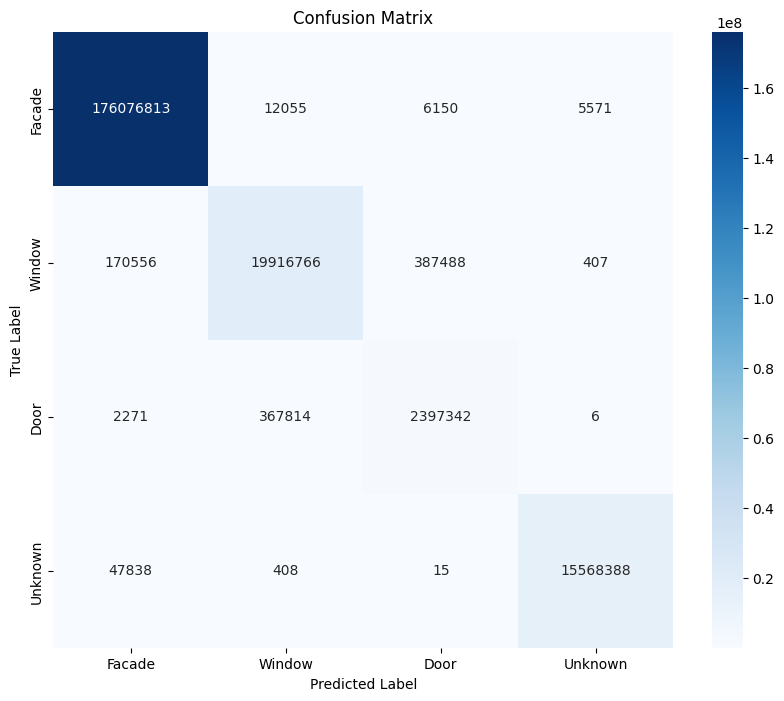


Test Set Results:
Global Accuracy: 0.9953

Per-class metrics:
  Class  Precision   Recall     Dice      IoU
 Facade   0.998748 0.999865 0.999278 0.998559
 Window   0.981264 0.972726 0.971713 0.948892
   Door   0.858956 0.866269 0.801432 0.756469
Unknown   0.999616 0.996910 0.991723 0.985521

Evaluation results saved to: /app/pth und eval/eval_results_20250319_1958.csv

Detailed Results:
  Class  Precision  Recall   Dice    IoU
 Facade     0.9987  0.9999 0.9993 0.9986
 Window     0.9813  0.9727 0.9717 0.9489
   Door     0.8590  0.8663 0.8014 0.7565
Unknown     0.9996  0.9969 0.9917 0.9855
   Mean     0.9596  0.9589 0.9410 0.9224


In [44]:
# a) CMP + Gen

target_dir_test = os.path.join(current_dir, "DATA", "Test_CMPGEN") #<-- change placeholder
visualize_eval(target_dir_test)


Evaluating model on test set...
Found 712 images in /app/DATA/Test_CMPGENREAL/ResizedConflictMaps
Found 712 images in /app/DATA/Test_CMPGENREAL/ResizedGroundTruth
Loading model from: /app/pth und eval/Facade_model_b14_e50_CMPGENREAL_nS.pth

Starting evaluation...
Starting evaluation...


100%|██████████| 178/178 [02:41<00:00,  1.10it/s]


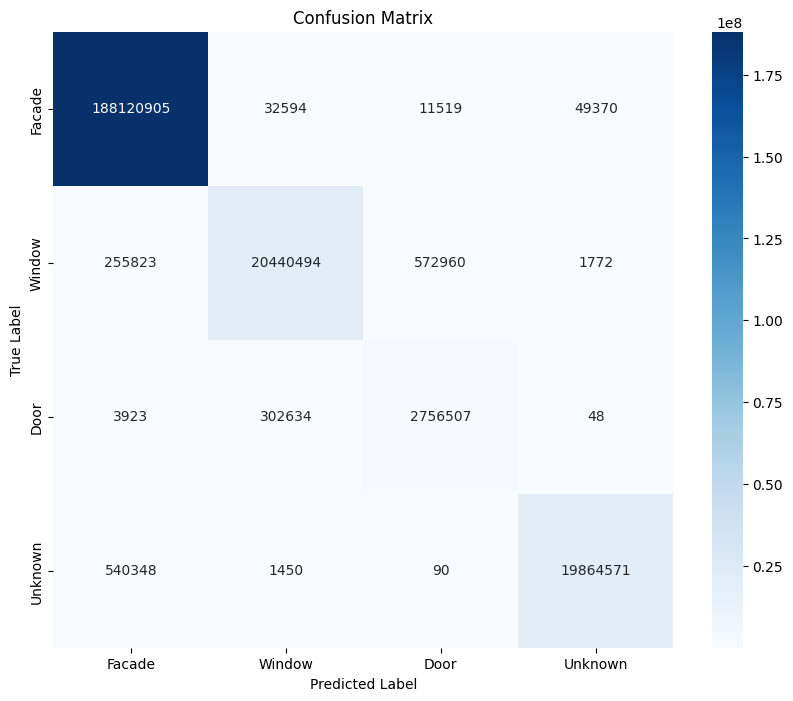


Test Set Results:
Global Accuracy: 0.9924

Per-class metrics:
  Class  Precision   Recall     Dice      IoU
 Facade   0.995765 0.999503 0.997163 0.994481
 Window   0.983796 0.960954 0.965119 0.937560
   Door   0.825036 0.899904 0.773495 0.736397
Unknown   0.997430 0.973445 0.834552 0.802831

Evaluation results saved to: /app/pth und eval/eval_results_20250319_2114.csv

Detailed Results:
  Class  Precision  Recall   Dice    IoU
 Facade     0.9958  0.9995 0.9972 0.9945
 Window     0.9838  0.9610 0.9651 0.9376
   Door     0.8250  0.8999 0.7735 0.7364
Unknown     0.9974  0.9734 0.8346 0.8028
   Mean     0.9505  0.9585 0.8926 0.8678


In [58]:
# b) CMP + Gen + Real

target_dir_test = os.path.join(current_dir, "DATA", "Test_CMPGENREAL") #<-- change placeholder
visualize_eval(target_dir_test)


Evaluating model on test set...
Found 55 images in /app/DATA/Test_REAL/ResizedConflictMaps
Found 55 images in /app/DATA/Test_REAL/ResizedGroundTruth
Loading model from: /app/pth und eval/Facade_model_b14_e50_CMPGENREAL_nS.pth

Starting evaluation...
Starting evaluation...


100%|██████████| 14/14 [00:14<00:00,  1.00s/it]


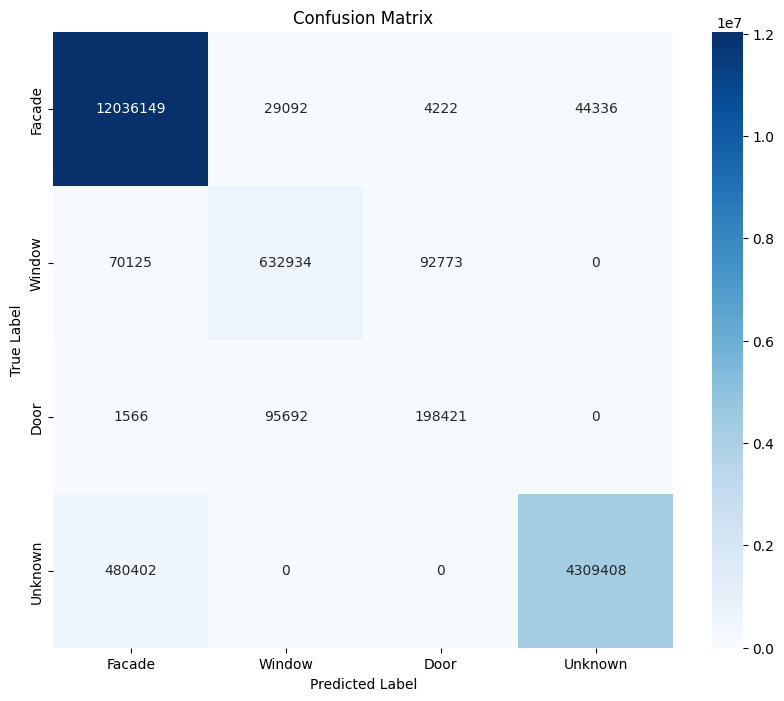


Test Set Results:
Global Accuracy: 0.9545

Per-class metrics:
  Class  Precision   Recall     Dice      IoU
 Facade   0.956142 0.993590 0.972594 0.947223
 Window   0.835316 0.795311 0.838470 0.728908
   Door   0.671666 0.671069 0.160191 0.142180
Unknown   0.989817 0.899703 0.938628 0.885829

Evaluation results saved to: /app/pth und eval/eval_results_20250319_2117.csv

Detailed Results:
  Class  Precision  Recall   Dice    IoU
 Facade     0.9561  0.9936 0.9726 0.9472
 Window     0.8353  0.7953 0.8385 0.7289
   Door     0.6717  0.6711 0.1602 0.1422
Unknown     0.9898  0.8997 0.9386 0.8858
   Mean     0.8632  0.8399 0.7275 0.6760


In [59]:
# c) Real

target_dir_test = os.path.join(current_dir, "DATA", "Test_REAL") #<-- change placeholder
visualize_eval(target_dir_test)

In [31]:
def classify_facade_image(model, input_image_path, input_gt_path, output_image_path, device):
    """
    Classifies a facade image with RGB conflict maps
    """
    # Updated color definitions for conflict map
    CONFLICT_MAP_COLORS = {
        'confirming': (0, 255, 0),  # Green - Confirming
        'unknown': (0, 0, 255),     # Blue - Unknown
        'conflict': (255, 0, 0)     # Red - Conflict
    }

    OUTPUT_COLORS = {
        0: (105, 105, 105),    # Facade - Grey
        1: (255, 255, 0),      # Window - Yellow
        2: (139, 69, 19),      # Door - Brown
        3: (220, 220, 220)     # Background/Occlusion - Light grey
    }

    GT_COLOR_MAP = {
        (0, 0, 255): 0,      # Blue -> Facade
        (0, 85, 255): 1,     # Light Blue -> Window
        (0, 170, 255): 2,    # Lighter Blue -> Door
        (0, 0, 170): 3       # Dark Blue -> Background/Occlusion
    }

    # Load images
    conf_map = Image.open(input_image_path).convert('RGB')
    ground_truth = np.array(Image.open(input_gt_path))

    # Convert conflict map to channel masks
    conf_map_array = np.array(conf_map)
    confirming_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['confirming'], axis=2)
    unknown_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['unknown'], axis=2)
    conflict_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['conflict'], axis=2)

    # Stack masks into tensor
    conf_map_tensor = np.stack([confirming_mask, unknown_mask, conflict_mask], axis=0)
    conf_map_tensor = torch.from_numpy(conf_map_tensor).float().unsqueeze(0).to(device)

    # Convert ground truth from RGB to class indices
    ground_truth_classes = np.zeros((ground_truth.shape[0], ground_truth.shape[1]), dtype=np.uint8)
    for rgb, class_idx in GT_COLOR_MAP.items():
        r, g, b = rgb
        mask = (ground_truth[:,:,0] == r) & (ground_truth[:,:,1] == g) & (ground_truth[:,:,2] == b)
        ground_truth_classes[mask] = class_idx

    # Color the ground truth using output color scheme
    colored_ground_truth = np.zeros((ground_truth_classes.shape[0], ground_truth_classes.shape[1], 3), dtype=np.uint8)
    for class_idx, color in OUTPUT_COLORS.items():
        colored_ground_truth[ground_truth_classes == class_idx] = color

    #print(colored_ground_truth)

    # Model prediction
    model.eval()
    with torch.no_grad():
        output = model(conf_map_tensor)

        #deB_classes = output[0][1]
        #print("deB_classes:", deB_classes)

        # CRINGE ? Wird hier von 0-3 auf 0-1 gesqueezt ?YOLO
        pred = output.argmax(1).squeeze().cpu().numpy()

        # Create colored prediction image
        colored_pred = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
        for class_idx, color in OUTPUT_COLORS.items():
            colored_pred[pred == class_idx] = color

        # Save prediction
        output_image = Image.fromarray(colored_pred)
        output_image.save(output_image_path)

        # Visualization
        plt.figure(figsize=(20, 5))

        # Plot original conflict map
        plt.subplot(1, 4, 1)
        plt.title("Input Conflict Map")
        plt.imshow(conf_map_array)
        plt.axis('off')

        # Plot individual channels
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        channel_names = ['Confirming (Green)', 'Unknown (Blue)', 'Conflict (Red)']
        for i, (mask, name) in enumerate(zip([confirming_mask, unknown_mask, conflict_mask], channel_names)):
            axes[i].imshow(mask, cmap='gray')
            axes[i].set_title(name)
            axes[i].axis('off')
        plt.tight_layout()

        # Plot results
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Input Conflict Map")
        plt.imshow(conf_map_array)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(colored_ground_truth)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Facade Elements")
        plt.imshow(colored_pred)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

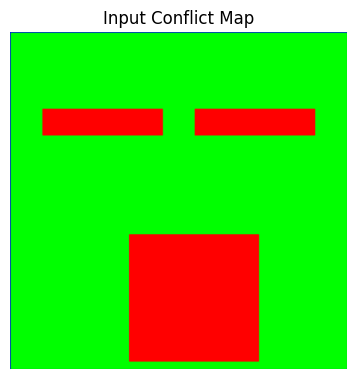

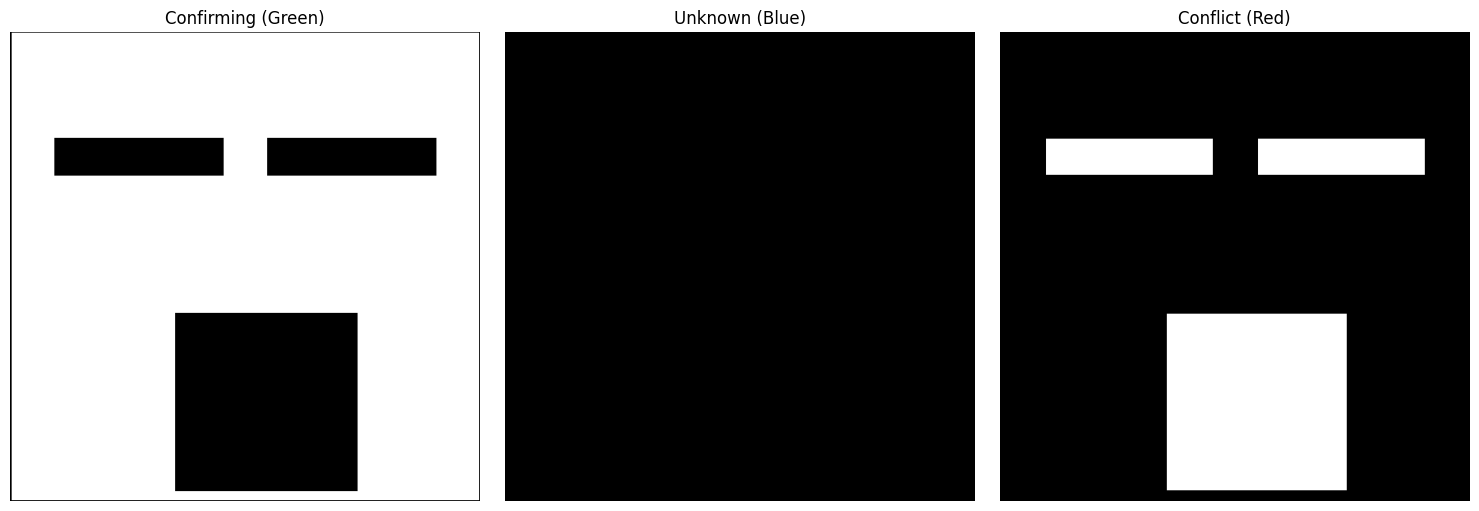

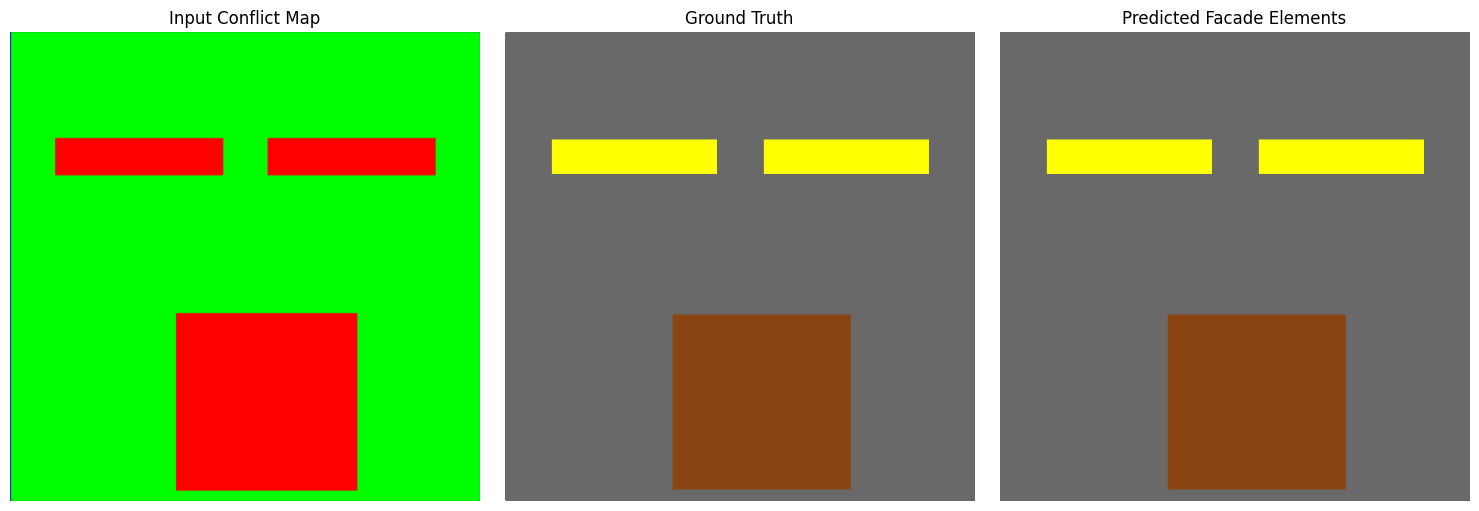

In [35]:
# Modellinstanz erstellen
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=4).to(device)

# Gewichte laden
model.load_state_dict(torch.load(model_weights_path, map_location=device))
model.eval()

target_dir_test = os.path.join(current_dir, "DATA", "Test_CMPGENREAL") #<-- change placeholder

# Plot eines Bildes

#input_image_path = os.path.join(target_dir_train, "ResizedConflictMaps", "conflict_map_1848.png")
#input_gt_path = os.path.join(target_dir_train, "ResizedGroundTruth", "ground_truth_1848.png")     # generator # 1848 without outperforms with !

input_image_path = os.path.join(target_dir_test,"ResizedConflictMaps", "conflict_map_111.png")
input_gt_path = os.path.join(target_dir_test, "ResizedGroundTruth", "ground_truth_111.png")      

output_image_path = os.path.join(target_dir_test, "ClassifiedImages", "unet_Gen_0.png")

# Load weights with correct argument syntax
#model.load_state_dict(torch.load(model_weights_path, map_location=device))

# Classify image
classify_facade_image(model, input_image_path,input_gt_path, output_image_path, device)

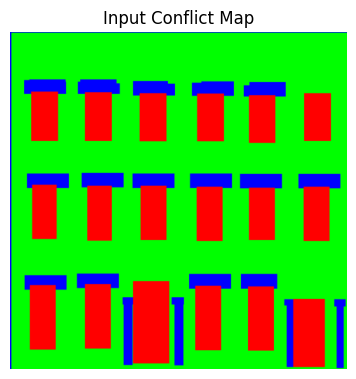

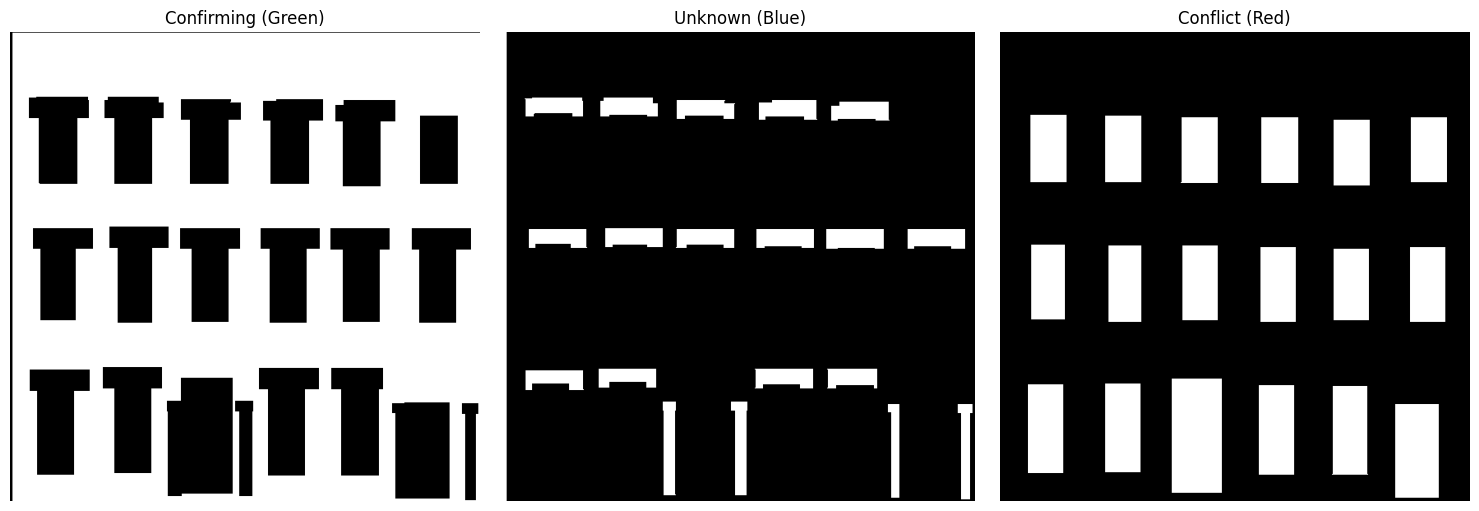

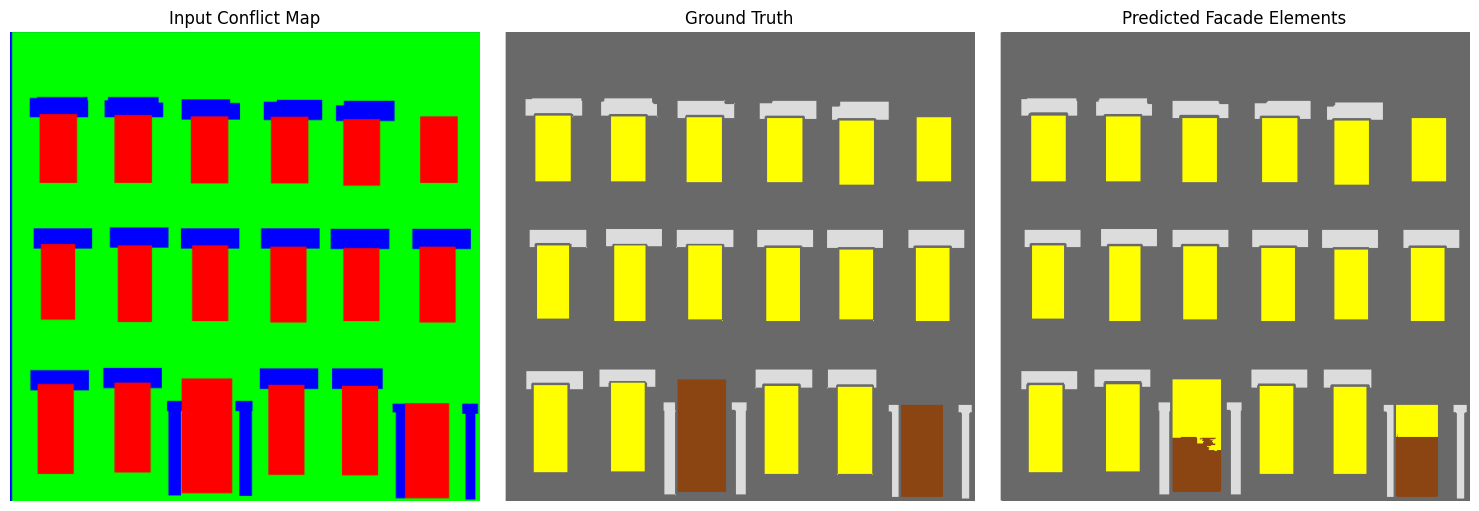

In [36]:
#model_weights_path = os.path.join(current_dir,"drive","MyDrive", "Colab Notebooks", "MultiClTest_facade_model.pth")

# Modellinstanz erstellen
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=4).to(device)

# Gewichte laden
model.load_state_dict(torch.load(model_weights_path, map_location=device))
model.eval()

# Plot eines Bildes

input_image_path = os.path.join(target_dir_test, "ResizedConflictMaps", "cmp_b0218.png") # Solid
input_gt_path = os.path.join(target_dir_test, "ResizedGroundTruth", "cmp_b0218.png")
output_image_path = os.path.join(target_dir_test, "ClassifiedImages", "unet_cmp_b0218.png")

#input_image_path = os.path.join(target_dir_train, "ResizedConflictMaps", "cmp_b0183.png") # Door when it touches blue beneath? Overfitting?
#input_gt_path = os.path.join(target_dir_train, "ResizedGroundTruth", "cmp_b0183.png")
#output_image_path = os.path.join(target_dir_test, "ClassifiedImages", "unet_cmp_b0183.png")

#input_image_path = os.path.join(target_dir_train, "ResizedConflictMaps", "cmp_b0108.png") # I also wouldn't be able to tell the difference
#input_gt_path = os.path.join(target_dir_train, "ResizedGroundTruth", "cmp_b0108.png")
#output_image_path = os.path.join(target_dir_test, "ClassifiedImages", "unet_cmp_b0108.png")

#input_image_path = os.path.join(target_dir_train, "ResizedConflictMaps", "cmp_b0254.png") # Performs okay with foreground beneath doors
#input_gt_path = os.path.join(target_dir_train, "ResizedGroundTruth", "cmp_b0254.png")
#output_image_path = os.path.join(target_dir_test, "ClassifiedImages", "unet_cmp_b0254.png")

#input_image_path = os.path.join(target_dir_train, "ResizedConflictMaps", "cmp_b0342.png") # No doors?
#input_gt_path = os.path.join(target_dir_train, "ResizedGroundTruth", "cmp_b0342.png")
#output_image_path = os.path.join(target_dir_test, "ClassifiedImages", "unet_cmp_b0342.png")

input_image_path = os.path.join(target_dir_test, "ResizedConflictMaps", "cmp_b0049.png") 
input_gt_path = os.path.join(target_dir_test, "ResizedGroundTruth", "cmp_b0049.png")
output_image_path = os.path.join(target_dir_test, "ClassifiedImages", "unet_cmp_b0049.png")


# Classify image
classify_facade_image(model, input_image_path,input_gt_path, output_image_path, device)

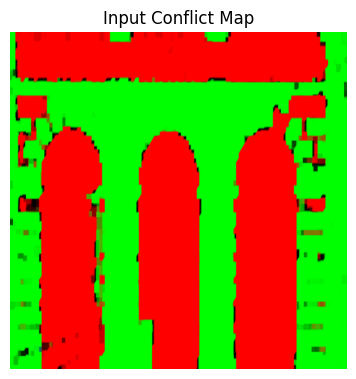

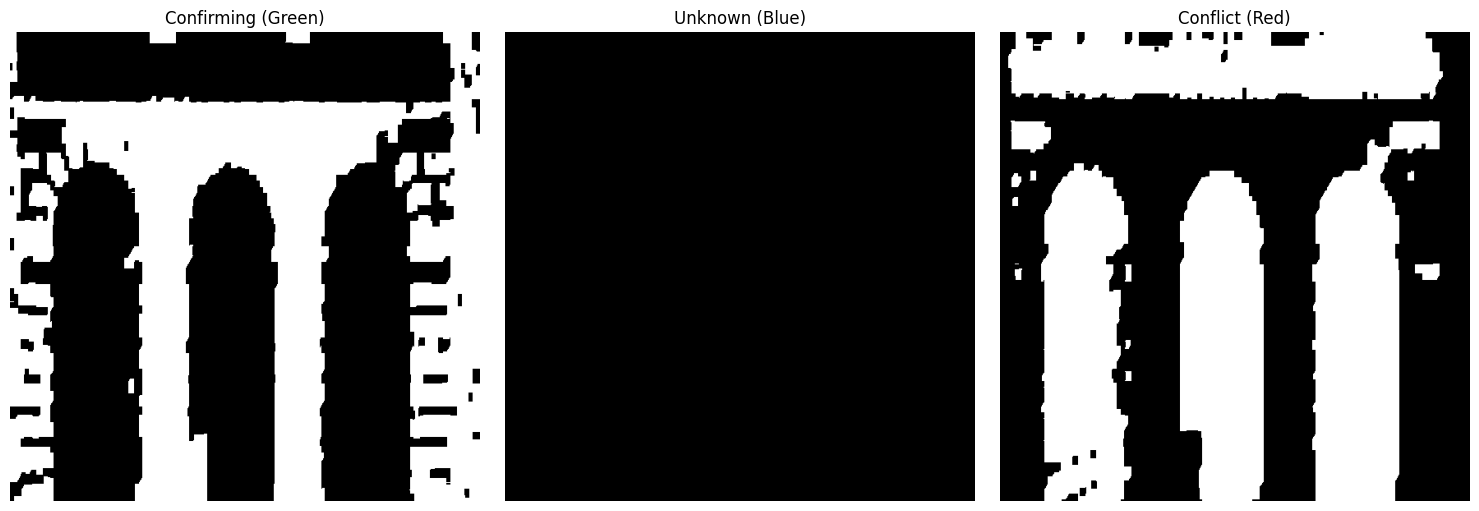

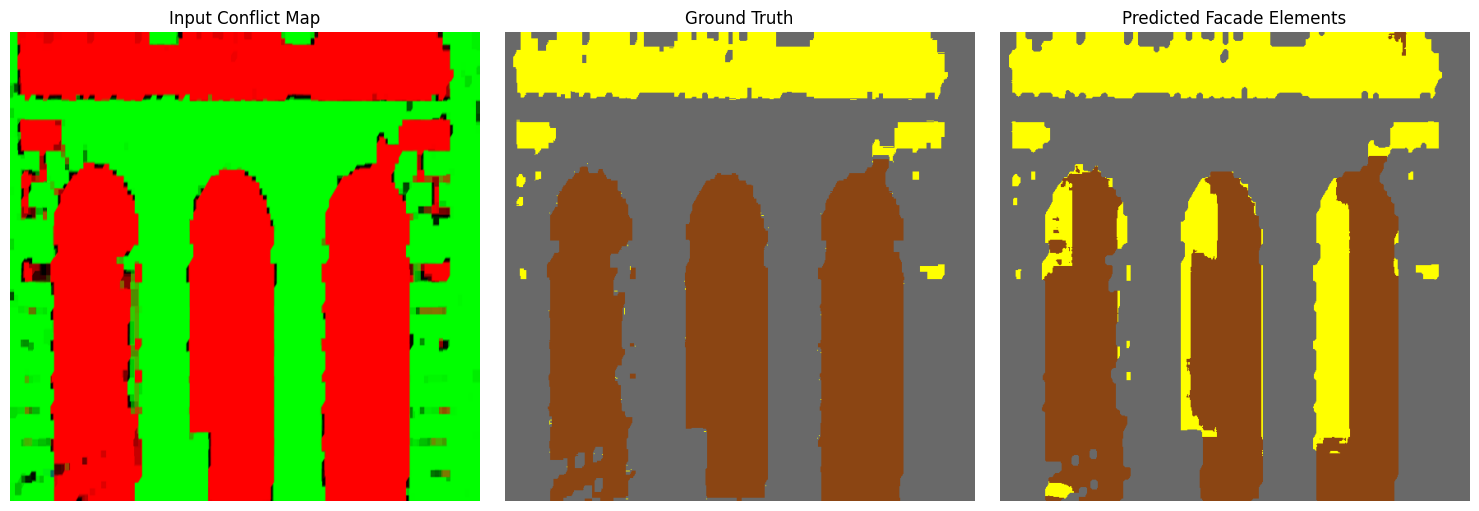

In [33]:
# Modellinstanz erstellen
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=4).to(device)

# Gewichte laden
model.load_state_dict(torch.load(model_weights_path, map_location=device))
model.eval()

input_image_path = os.path.join(target_dir_test,"ResizedConflictMaps", "015_7_conflict_map_3277 (3).png")
input_gt_path = os.path.join(target_dir_test, "ResizedGroundTruth", "015_7_conflict_map_3277 (3).png")      
output_image_path = os.path.join(target_dir_test, "ClassifiedImages", "unet_Gen_0.png")

# Classify image
classify_facade_image(model, input_image_path,input_gt_path, output_image_path, device)

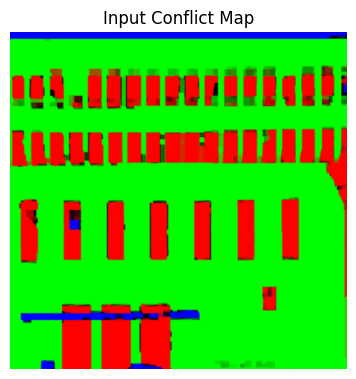

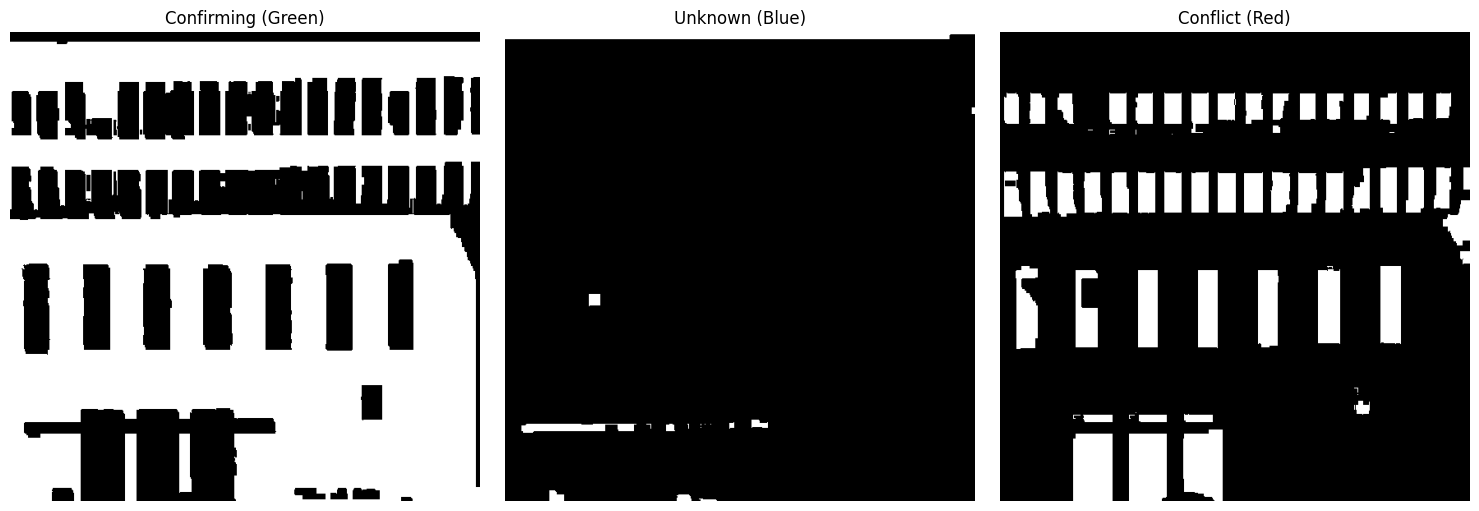

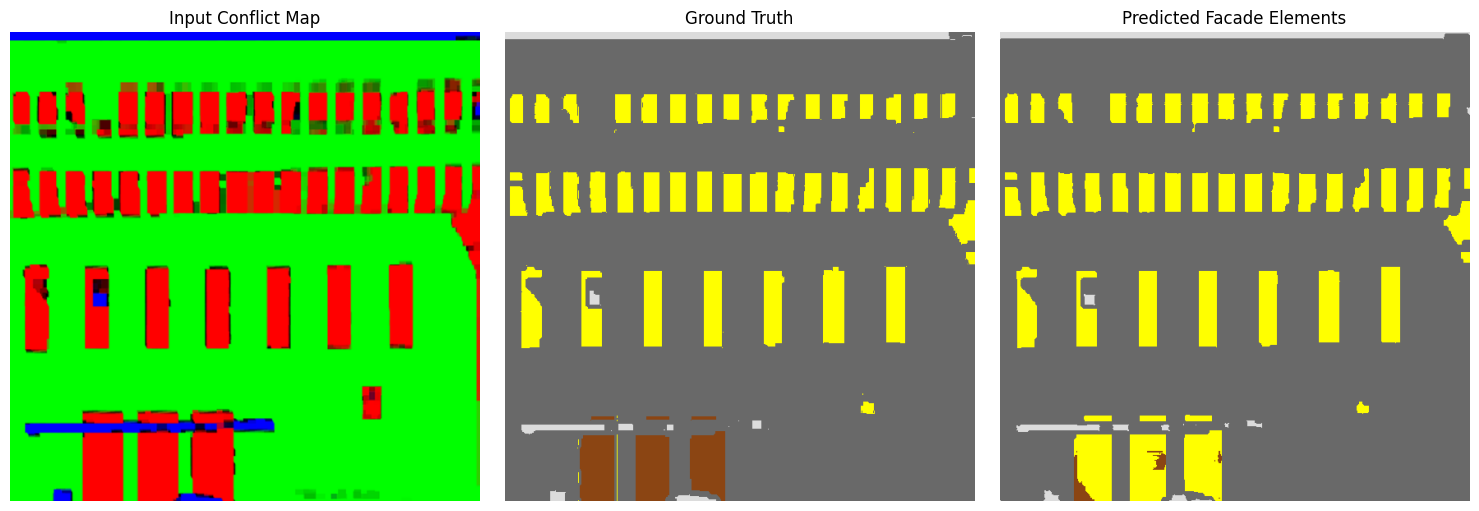

In [48]:
# Modellinstanz erstellen
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=4).to(device)

# Gewichte laden
model.load_state_dict(torch.load(model_weights_path, map_location=device))
model.eval()

input_image_path = os.path.join(target_dir_test,"ResizedConflictMaps", "029_7_conflict_map_3225.png")
input_gt_path = os.path.join(target_dir_test, "ResizedGroundTruth", "029_7_conflict_map_3225.png")      
output_image_path = os.path.join(target_dir_test, "ClassifiedImages", "unet_Gen_0.png")

# Classify image
classify_facade_image(model, input_image_path,input_gt_path, output_image_path, device)

# Extracting Logits to Fuse with Mask-RCNN

In [37]:
def extract_normalized_probabilities(model, input_image_path, device, save_visualization=True, output_dir=None):
    """
    Extracts normalized probability matrices for each class from the UNet model

    Parameters:
        model: trained UNet model
        input_image_path: path to input conflict map
        device: torch device (cpu or cuda)
        save_visualization: whether to save visualizations
        output_dir: directory to save visualizations (optional)

    Returns:
        normalized_probs: numpy array of shape [num_classes, height, width]
        class_probs: dictionary mapping class names to probability matrices
    """
    # Color mappings for conflict map
    CONFLICT_MAP_COLORS = {
        'confirming': (0, 255, 0),  # Green - Confirming
        'unknown': (0, 0, 255),     # Blue - Unknown
        'conflict': (255, 0, 0)     # Red - Conflict
    }

    # Class names for your facade elements
    class_names = ['Facade', 'Window', 'Door', 'Unknown']

    # Load and preprocess input
    conf_map = Image.open(input_image_path).convert('RGB')
    conf_map_array = np.array(conf_map)

    # Convert conflict map to channel masks
    confirming_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['confirming'], axis=2)
    unknown_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['unknown'], axis=2)
    conflict_mask = np.all(conf_map_array == CONFLICT_MAP_COLORS['conflict'], axis=2)

    # Stack masks into tensor
    conf_map_tensor = np.stack([confirming_mask, unknown_mask, conflict_mask], axis=0)
    conf_map_tensor = torch.from_numpy(conf_map_tensor).float().unsqueeze(0).to(device)

    # Get model output without gradients
    model.eval()
    with torch.no_grad():
        # Get raw logits from model
        logits = model(conf_map_tensor)

        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=1)

        # Convert to numpy for easier manipulation
        normalized_probs = probs.squeeze().cpu().numpy()

    # Create dictionary to store class probabilities
    class_probs = {}
    for i, class_name in enumerate(class_names):
        class_probs[class_name] = normalized_probs[i]

    if save_visualization:
        # Create visualization of the class probabilities
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # Plot original conflict map
        axes[0, 0].imshow(conf_map_array)
        axes[0, 0].set_title("Input Conflict Map", fontsize=14)
        axes[0, 0].axis('off')

        # Plot probability maps for each class
        for i, class_name in enumerate(class_names):
            # Calculate row, col position in the grid
            row = (i + 1) // 3
            col = (i + 1) % 3

            # Get the probability matrix for this class
            prob_matrix = class_probs[class_name]

            # Plot the probability matrix
            im = axes[row, col].imshow(prob_matrix, cmap='Blues', vmin=0, vmax=1)
            axes[row, col].set_title(f"{class_name} Probability", fontsize=14)
            axes[row, col].axis('off')

            # Add colorbar
            fig.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)

        # Hide the empty subplot
        axes[1, 2].axis('off')

        plt.tight_layout()

        # Save visualization if output directory is provided
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            plt.savefig(os.path.join(output_dir, "class_probabilities.png"), dpi=300, bbox_inches='tight')

        plt.show()

        # Visualize confidence map (max probability at each pixel)
        confidence_map = np.max(normalized_probs, axis=0)

        plt.figure(figsize=(10, 8))
        plt.imshow(confidence_map, cmap='hot', vmin=0, vmax=1)
        plt.colorbar(label='Confidence')
        plt.title("Model Confidence (Max Probability)", fontsize=16)
        plt.axis('on')
        plt.grid()

        # Save confidence map if output directory is provided
        if output_dir:
            plt.savefig(os.path.join(output_dir, "confidence_map.png"), dpi=300, bbox_inches='tight')

        plt.show()

    return normalized_probs, class_probs

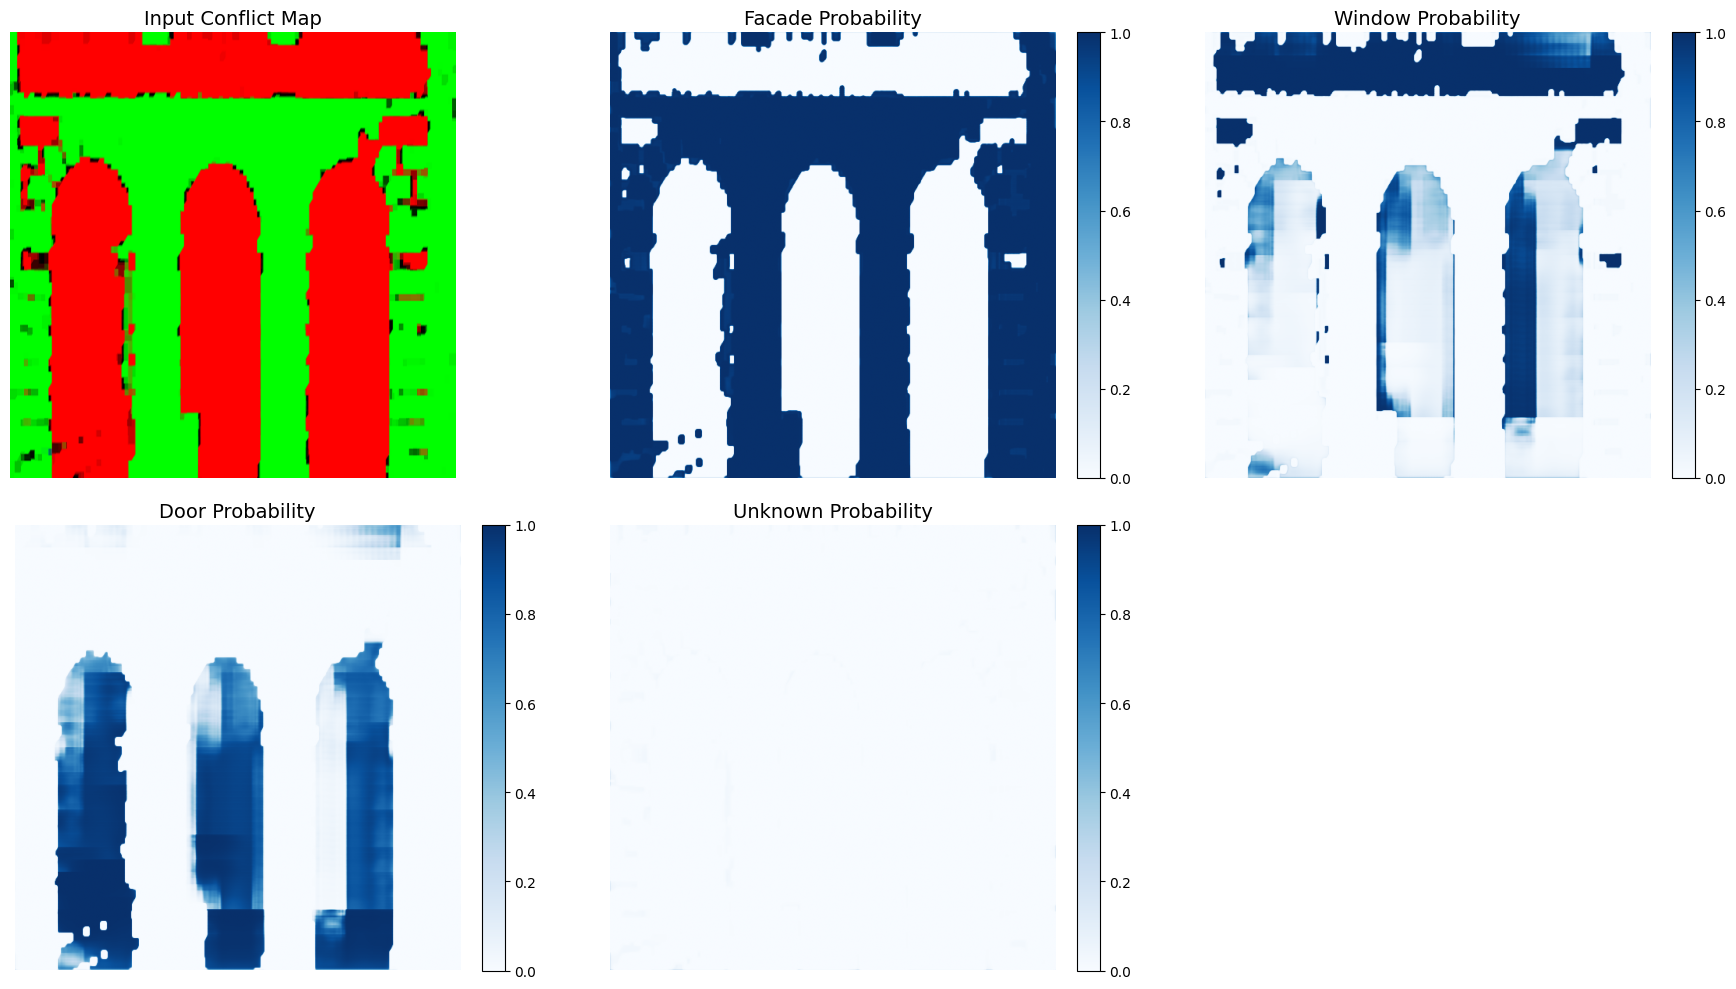

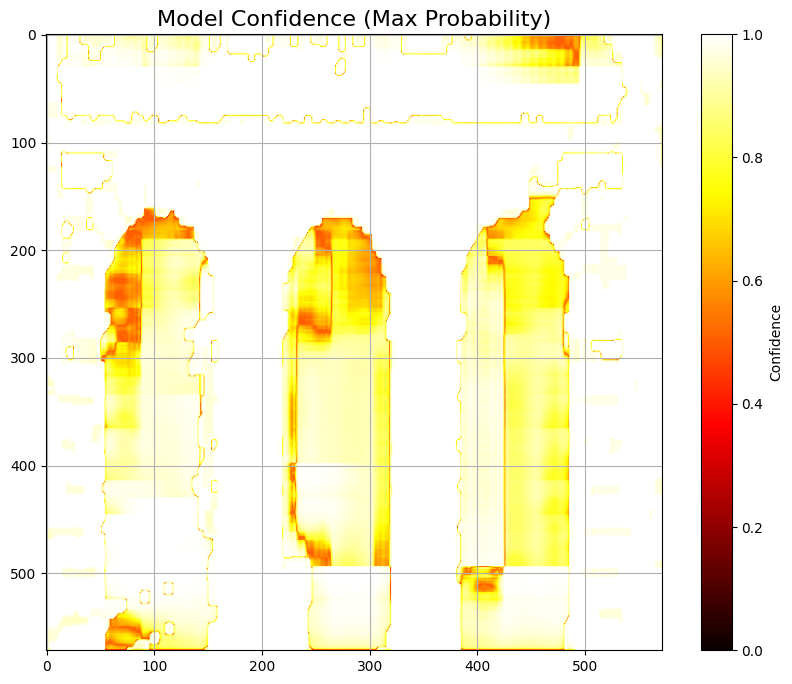

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=4).to(device)
model.load_state_dict(torch.load(model_weights_path, map_location=device))

input_image_path = os.path.join(target_dir_test, "ResizedConflictMaps", "015_7_conflict_map_3277 (3).png")

normalized_probs, class_probs = extract_normalized_probabilities(
    model=model,
    input_image_path=input_image_path,  # Your conflict map image
    device=device,
    output_dir="probability_visualizations"  # Optional
)

# Class probabilities by name
facade_prob = class_probs['Facade']     # 2D array with probability values
window_prob = class_probs['Window']
door_prob = class_probs['Door']
unknown_prob = class_probs['Unknown']

# # ARRAY we need
# # Shape: [num_classes, height, width]
# # normalized_probs[0] = facade probabilities
# # normalized_probs[1] = window probabilities
# # normalized_probs[2] = door probabilities
# # normalized_probs[3] = unknown probabilities

In [40]:
# Confidence for a specific pixel

#pixel = (row,col) = (y,x)
pixel =  (200,202)
pixel_conf = []

pixel_conf.append(facade_prob[pixel])
pixel_conf.append(window_prob[pixel])
pixel_conf.append(door_prob[pixel])
pixel_conf.append(unknown_prob[pixel])

print("Confidence Vector:", pixel_conf)

# sanity
print("Probability adds up to:",round(sum(pixel_conf)))

Confidence Vector: [0.9999999, 5.5677418e-11, 3.9791618e-11, 7.255125e-08]
Probability adds up to: 1
